In [1]:
import sys
sys.path.append(r'..//')
from ioMicro import *

In [2]:
def apply_flat_field(dec,tag=r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\DriftAcrossDatasets\med_col_raw'):
    ### load the immeds
    Icol = dec.XH_pruned[:,:,-2].astype(int)
    uIcols = np.unique(Icol)
    dec.ncols = len(uIcols)
    #save_folder=dec.save_folder#r'\\192.168.0.10\bbfishdc13\DCBBL1_3_2_2023\MERFISH_Analysis'
    immeds = []
    for icol in range(dec.ncols):
        fl_med = tag+str(icol)+'.npz'
        if not os.path.exists(fl_med):
            fl_med = fl_med.replace('_raw','')
        dic = np.load(fl_med)
        immed,resc=dic['im'],dic['resc']
        immeds.append(immed)
    dec.immeds = np.array(immeds)
    dec.resc = resc
    
    ### renormalize the brightness according to flatfield
    XH = dec.XH_pruned
    Icol = XH[:,:,-2].astype(int)
    H = dec.XH_pruned[:,:,-3].copy()
    for icol in range(dec.ncols):
        keep = Icol==icol
        immed = dec.immeds[icol].copy()
        immed = immed/np.median(immed)
        x_,y_ = ((XH[keep][:,1:3]/dec.resc).astype(int)%immed.shape).T
        norm_ = immed[x_,y_] 
        H[keep]=H[keep]/norm_
    dec.XH_pruned[:,:,-3] = H


def main_analysisV1(fov,set_,
                   save_folder = r'\\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12',
                   save_fl_ref = r'\\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12\scoresRef.npy',
                   save_folder_all = r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpots',
                   drift_folder = r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\DriftAcrossDatasets',
                   segm_tag = 'A1_LamA_Nup98_D16',redo=False,resc=[2,2,2],
                   drift_semgentation = np.array([  -2.5602207, -486.3025   ,   -5.648471 ])):


    if not os.path.exists(save_folder_all): os.makedirs(save_folder_all)
    save_fl = save_folder_all+os.sep+'saveDecodedFinalV1--'+os.path.basename(save_folder)+'--'+fov.split('.')[0]+'--'+set_+'.npz'
    dec = None
    if not os.path.exists(save_fl) or redo:
        ####### Load in the decoded spot data #############################
        #fov,set_ = 'Conv_zscan__040', '_D16' ################## Change 
        dec = decoder_simple(save_folder,fov,set_)
        dec.ncols = 3
        dec.load_decoded()
        print("Molecules size:",dec.XH_pruned.shape)
        print("Covering reaoduts:",np.unique(dec.XH_pruned[:,:,-1]))
        apply_fine_drift(dec,plt_val=True)
        apply_flat_field(dec)
        #scoresRefT = get_score_per_color(dec)
        scoresRef = np.load(save_fl_ref,allow_pickle=True)
        get_score_withRef(dec,scoresRef,plt_val=True,gene=None,iSs = None,th_min=-10)
        dec.th=-0.5
        plot_statistics(dec)

        ####### Threhold the decoded spot data #############################
        keepf =  dec.scoreA>dec.th ### keep good score
        icodesf = dec.icodesN[keepf]
        XHfpr = dec.XH_pruned[keepf]

        ### Reorganize data  ###############################
        XHf = np.mean(XHfpr,axis=1)
        XF = XHf[:,[0,1,2,-5,-4,-3,-2,-1,-1,-1,-1]]
        #zc,xc,yc,bk-7,a-6,habs-5,hn-4,h-3
        XF[:,-1] = dec.scoreA[keepf]
        XF[:,-2] = np.where(keepf)[0]
        mnD = np.mean(np.linalg.norm((XHf[:,np.newaxis]-XHfpr)[:,:,:3],axis=-1),axis=-1)
        XF[:,-3]=mnD
        mnH = np.mean(np.abs((XHf[:,np.newaxis]-XHfpr)[:,:,-3]),axis=-1)
        XF[:,-4]=mnH
        genesf = dec.gns_names[icodesf]

        ### Apply drift to match the segmentation reference ########################
        def get_drft_dic(fl_all_drift):
            drft,flds,fov_,fl_ref= np.load(fl_all_drift,allow_pickle=True)
            return {('--'.join(fld.split(os.sep)[-2:]) if '--' in os.path.basename(fld) else os.path.basename(fld)):drft_[0] 
                    for fld,drft_ in zip(flds,drft)}

        fl_all_drift = drift_folder+os.sep+'driftNew_'+dec.fov+'--'+dec.set_+'.pkl'
        drft_dic_all = get_drft_dic(fl_all_drift)
        fl_all_drift = save_folder+os.sep+'driftNew_'+dec.fov+'--'+dec.set_+'.pkl'
        drft_dic_group = get_drft_dic(fl_all_drift)
        key_segm = [key for key in drft_dic_all if segm_tag in key][0]
        key_align = np.intersect1d(list(drft_dic_all.keys()),list(drft_dic_group.keys()))[0]
        if drift_semgentation is None:
            drift_semgentation = drft_dic_all[key_segm]
        th1_to_h0 = drift_semgentation-drft_dic_all[key_align]
        th1_gr = drft_dic_group[key_align]
        tzxyf = th1_gr+th1_to_h0

        XF[:,:3]=XF[:,:3]-tzxyf #### do not add here

        
                
        ### Load in the current fov segmentation ######################################
        ifov = fovs.index(dec.fov)
        coords= coordsf[ifov]
        xIm,xIM,yIm,yIM = coords[0],coords[1],coords[2],coords[3]
        min_ = np.min(XF[:,:3],axis=0)
        max_ = np.max(XF[:,:3],axis=0)

        xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
        ### deal with the case of outside image
        Im = np.array([xIm,yIm])
        min_[1:]=min_[1:]-Im*(Im<0)*resc[1:]
        ### recenter
        xIm,xIM,yIm,yIM = coords[0],coords[1],coords[2],coords[3]
        xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
        XF__=XF[:,:3]-min_
        xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
        dec.im_segm_ = imfsegm[:,xIm:xIM,yIm:yIM]
        dec.XF__ = XF__
        dec.XF = XF
        dec.resc = resc

        #### get cell ids #######################
        def get_cell_id(dec,Xh,resc=[2,2,2],plot_val = False):
            if not hasattr(dec,'im_segm_'): 
                good = np.ones(len(Xh),dtype=bool)
                cells_ = np.zeros(len(Xh),dtype=int)
                return cells_,good
            im_segm = dec.im_segm_
            dec.shapesm = dec.im_segm_.shape
            Xcms = Xh[:,:3]
            Xred = np.round(Xcms/resc).astype(int)
            good = ~np.any((Xred>=dec.shapesm)|(Xred<0),axis=-1)
            Xred = Xred[good]
            if plot_val:
                v = napari.view_points(Xred,size=1.5)
                v.add_labels(im_segm)
            return im_segm[tuple(Xred.T)],good


        cell_id,good =get_cell_id(dec,XF__,resc=resc,plot_val = False)
        #XF_ = np.concatenate([XF[good],cell_id[:,np.newaxis]],axis=-1)
        genesf_ = genesf[good]
        iset = int(dec.set_.split('_D')[-1])
        ifov = int(dec.fov.split('_')[-1].split('.')[0])
        isets = np.array([iset]*len(cell_id))[:,np.newaxis]
        ifovs = np.array([ifov]*len(cell_id))[:,np.newaxis]
        cell_id = cell_id[:,np.newaxis]
        XF_ = np.concatenate([XF[good],cell_id,ifovs,isets],axis=-1)

        #get_xyfov(dec)
        ### add absolute positiuons of molecules in um
        pixel_size = np.array([0.4,0.10833,0.10833])*resc
        XF_ = XF_[:,list(np.arange(XF_.shape[-1]))+[-1,-1,-1]]
        XF_[:,-3:]=((XF_[:,:3]/resc)+[0,coords[0],coords[2]])*pixel_size
        header = ['z','x','y','abs_brightness','cor','brightness','color','mean_bightness_variation','mean_distance_variation',
                  'index_from_XH_pruned','score','cell_id','ifov','iset','z_um_abs','x_um_abs','y_um_abs']


        ##### get info for cells #########################
        if not hasattr(dec,'im_segm_'): dec.im_segm_=np.zeros(np.array([30,3000,3000])//2)
        icells,vols = np.unique(dec.im_segm_,return_counts=True)
        cms = np.array(ndimage.center_of_mass(np.ones_like(dec.im_segm_),dec.im_segm_,icells))
        #icells,vols = np.unique(dec.im_segm_,return_counts=True)
        cms = np.array(ndimage.center_of_mass(np.ones_like(dec.im_segm_),dec.im_segm_,icells))

        cells_abs_pos = (cms+[0,coords[0],coords[2]])*pixel_size

        cellinfo = cms[:,[0,0,0,1,2,0,0,0]]
        cellinfo[:,0]=icells
        cellinfo[:,1]=vols
        cellinfo[:,-3:]=cells_abs_pos

        header_cells = ['cell_id','volm','zc','xc','yc','z_um_abs','x_um_abs','y_um_abs']
        plt.close('all')

        if True:
            np.savez_compressed(save_fl,XF=XF_.astype(np.float32),
                                genes = genesf_,cellinfo=cellinfo.astype(np.float32),header_cells=header_cells,header=header)
        print("Finished",save_fl)
    return dec

In [3]:
dic_ = np.load(r'\\192.168.0.6\bbfishjoy4extra\SegmentationCyto2\imfsegm.npz')################
imfsegm = dic_['imfsegm']
coordsf=dic_['coordsf']
resc = dic_['resc']
dic = np.load(r'\\192.168.0.6\bbfishjoy4extra\SegmentationCyto2\pos_um_fovs.npz')##################
pos=dic['pos']
fls=dic['fls']
fovs = [os.path.basename(fl).split('--')[0]for fl in fls]
set_ = '_'+os.path.basename(fls[0]).split('--')[1].split('_')[-1]

In [4]:
save_folders = [r'\\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12',
                r'\\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP34',
                r'\\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1',
                r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP56',
                r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP711',
                r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisE2']
for fld in save_folders:
    print(os.path.exists(fld))

True
True
True
True
True
True


In [5]:
paramaters = [(fov,set_,save_folder)for fov in fovs for save_folder in save_folders]
len(paramaters)

1554

  0%|                                                                                         | 0/1554 [00:00<?, ?it/s]

Loaded decoded: -37.63684868812561
Molecules size: (6145054, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  0%|                                                                             | 1/1554 [01:58<50:58:22, 118.16s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__258--_D16.npz
Loaded decoded: -29.815751791000366
Molecules size: (12439511, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  0%|                                                                             | 2/1554 [04:06<53:29:31, 124.08s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__258--_D16.npz
Loaded decoded: -18.313556909561157
Molecules size: (13205580, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  0%|▏                                                                            | 3/1554 [05:52<49:58:42, 116.00s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__258--_D16.npz
Loaded decoded: -16.486964464187622
Molecules size: (6707844, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  0%|▏                                                                            | 4/1554 [07:08<43:09:55, 100.26s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__258--_D16.npz
Loaded decoded: -28.12607169151306
Molecules size: (9729004, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  24.5 25.  25.5
 26.  26.5 27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5
 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5
 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5
 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.78it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__258--_D16.npz


  0%|▏                                                                            | 5/1554 [09:12<46:46:41, 108.72s/it]

Loaded decoded: -41.059152126312256
Molecules size: (16359874, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  0%|▎                                                                            | 6/1554 [12:32<60:05:05, 139.73s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__258--_D16.npz
Loaded decoded: -10.097500562667847
Molecules size: (6735249, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  0%|▎                                                                            | 7/1554 [14:05<53:27:25, 124.40s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__257--_D16.npz
Loaded decoded: -50.350889682769775
Molecules size: (16288721, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:26<00:00,  1.81it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__257--_D16.npz


  1%|▍                                                                            | 8/1554 [17:36<65:16:00, 151.98s/it]

Loaded decoded: -34.63529372215271
Molecules size: (17297372, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:26<00:00,  1.79it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__257--_D16.npz


  1%|▍                                                                            | 9/1554 [20:49<70:45:08, 164.86s/it]

Loaded decoded: -17.27862524986267
Molecules size: (7484556, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  1%|▍                                                                           | 10/1554 [22:29<62:06:59, 144.83s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__257--_D16.npz
Loaded decoded: -54.83769416809082
Molecules size: (13254946, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  24.5 25.  25.5
 26.  26.5 27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5
 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5
 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5
 47.  47.5]



  1%|▌                                                                           | 11/1554 [25:42<68:25:45, 159.65s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__257--_D16.npz
Loaded decoded: -171.79941177368164
Molecules size: (24223068, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:37<00:00,  1.27it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__257--_D16.npz


  1%|▌                                                                          | 12/1554 [32:30<100:41:29, 235.08s/it]

Loaded decoded: -14.979358673095703
Molecules size: (2207078, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  1%|▋                                                                           | 13/1554 [33:53<80:52:09, 188.92s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__256--_D16.npz
Loaded decoded: -11.37321949005127
Molecules size: (7373630, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  1%|▋                                                                           | 14/1554 [35:29<68:49:49, 160.90s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__256--_D16.npz
Loaded decoded: -23.559528827667236
Molecules size: (7792324, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   7.   8.   9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  1%|▋                                                                           | 15/1554 [37:24<62:56:39, 147.24s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__256--_D16.npz
Loaded decoded: -78.49428606033325
Molecules size: (2341674, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  1%|▊                                                                           | 16/1554 [39:20<58:50:15, 137.72s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__256--_D16.npz
Loaded decoded: -23.29711365699768
Molecules size: (7229010, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  37.  38.  39.  39.5 40.  40.5 41.  41.5 42.  42.5
 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  1%|▊                                                                           | 17/1554 [41:15<55:51:46, 130.84s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__256--_D16.npz
Loaded decoded: -25.478334188461304
Molecules size: (15202865, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:24<00:00,  1.95it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__256--_D16.npz


  1%|▉                                                                           | 18/1554 [44:02<60:28:28, 141.74s/it]

Loaded decoded: -3.4655115604400635
Molecules size: (1951614, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  1%|▉                                                                           | 19/1554 [44:53<48:50:06, 114.53s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__255--_D16.npz
Loaded decoded: -9.01854419708252
Molecules size: (6156545, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  1%|▉                                                                           | 20/1554 [46:09<43:50:17, 102.88s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__255--_D16.npz
Loaded decoded: -8.721523761749268
Molecules size: (6344407, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  1%|█                                                                            | 21/1554 [47:31<41:12:04, 96.75s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__255--_D16.npz
Loaded decoded: -30.587135076522827
Molecules size: (2062154, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  1%|█                                                                            | 22/1554 [48:46<38:17:59, 90.00s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__255--_D16.npz
Loaded decoded: -16.207197904586792
Molecules size: (6495495, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  37.  38.  39.  39.5 40.  40.5 41.  41.5 42.  42.5
 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  1%|█▏                                                                           | 23/1554 [50:18<38:36:51, 90.80s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__255--_D16.npz
Loaded decoded: -84.26269960403442
Molecules size: (13945296, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:23<00:00,  2.03it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__255--_D16.npz


  2%|█▏                                                                          | 24/1554 [54:10<56:33:59, 133.10s/it]

Loaded decoded: -0.7676663398742676
Molecules size: (434736, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  33.  34.  35.  36.  37.
 38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  2%|█▏                                                                           | 25/1554 [54:30<42:07:10, 99.17s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__254--_D16.npz
Loaded decoded: -3.484203338623047
Molecules size: (2592983, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  2%|█▎                                                                           | 26/1554 [55:33<37:29:46, 88.34s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__254--_D16.npz
Loaded decoded: -4.8728532791137695
Molecules size: (3249209, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  2%|█▎                                                                           | 27/1554 [56:21<32:20:02, 76.23s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__254--_D16.npz
Loaded decoded: -0.9500553607940674
Molecules size: (603091, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  2%|█▍                                                                           | 28/1554 [57:04<28:04:08, 66.22s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__254--_D16.npz
Loaded decoded: -3.713205099105835
Molecules size: (2218884, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  2%|█▍                                                                           | 29/1554 [57:44<24:47:09, 58.51s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__254--_D16.npz
Loaded decoded: -30.733760595321655
Molecules size: (9557587, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  2%|█▍                                                                           | 30/1554 [59:34<31:16:44, 73.89s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__254--_D16.npz
Loaded decoded: -0.7220497131347656
Molecules size: (432243, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  2%|█▍                                                                         | 31/1554 [1:00:00<25:10:23, 59.50s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__253--_D16.npz
Loaded decoded: -8.532244205474854
Molecules size: (1924632, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  2%|█▌                                                                         | 32/1554 [1:00:42<22:58:49, 54.36s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__253--_D16.npz
Loaded decoded: -3.5300166606903076
Molecules size: (1803611, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  2%|█▌                                                                         | 33/1554 [1:01:12<19:50:24, 46.96s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__253--_D16.npz
Loaded decoded: -6.059474945068359
Molecules size: (526410, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  2%|█▋                                                                         | 34/1554 [1:01:39<17:19:26, 41.03s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__253--_D16.npz
Loaded decoded: -12.781301736831665
Molecules size: (1711734, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  2%|█▋                                                                         | 35/1554 [1:02:22<17:31:45, 41.54s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__253--_D16.npz
Loaded decoded: -19.451762437820435
Molecules size: (4251358, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  2%|█▋                                                                         | 36/1554 [1:03:25<20:16:14, 48.07s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__253--_D16.npz
Loaded decoded: -0.9179728031158447
Molecules size: (452205, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  2%|█▊                                                                         | 37/1554 [1:03:41<16:09:42, 38.35s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__252--_D16.npz
Loaded decoded: -3.014029026031494
Molecules size: (2278028, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  2%|█▊                                                                         | 38/1554 [1:04:13<15:18:14, 36.34s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__252--_D16.npz
Loaded decoded: -3.5016660690307617
Molecules size: (2598599, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  3%|█▉                                                                         | 39/1554 [1:05:06<17:26:51, 41.46s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__252--_D16.npz
Loaded decoded: -0.9072649478912354
Molecules size: (604067, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  3%|█▉                                                                         | 40/1554 [1:05:32<15:24:26, 36.64s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__252--_D16.npz
Loaded decoded: -3.50040602684021
Molecules size: (2144136, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  3%|█▉                                                                         | 41/1554 [1:06:08<15:24:07, 36.65s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__252--_D16.npz
Loaded decoded: -14.342799425125122
Molecules size: (7903080, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  3%|██                                                                         | 42/1554 [1:07:32<21:23:30, 50.93s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__252--_D16.npz
Loaded decoded: -1.0922179222106934
Molecules size: (520798, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  33.  34.  35.  36.  37.
 38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  3%|██                                                                         | 43/1554 [1:08:12<19:58:58, 47.61s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__251--_D16.npz
Loaded decoded: -4.614619255065918
Molecules size: (3273560, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  3%|██                                                                         | 44/1554 [1:09:13<21:34:28, 51.44s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__251--_D16.npz
Loaded decoded: -5.69165825843811
Molecules size: (4187416, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  3%|██▏                                                                        | 45/1554 [1:10:11<22:23:19, 53.41s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__251--_D16.npz
Loaded decoded: -1.4817314147949219
Molecules size: (801023, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  3%|██▏                                                                        | 46/1554 [1:10:41<19:24:58, 46.35s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__251--_D16.npz
Loaded decoded: -14.69934344291687
Molecules size: (2846882, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  3%|██▎                                                                        | 47/1554 [1:11:31<19:52:53, 47.49s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__251--_D16.npz
Loaded decoded: -52.59933662414551
Molecules size: (11184351, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  3%|██▎                                                                        | 48/1554 [1:13:57<32:17:14, 77.18s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__251--_D16.npz
Loaded decoded: -1.0529403686523438
Molecules size: (692209, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  3%|██▎                                                                        | 49/1554 [1:14:19<25:17:07, 60.48s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__250--_D16.npz
Loaded decoded: -5.935378789901733
Molecules size: (4092103, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  13.  14.  15.
 16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
 30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.
 44.  45.  46.  47. ]



  3%|██▍                                                                        | 50/1554 [1:15:02<23:10:20, 55.47s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__250--_D16.npz
Loaded decoded: -18.314460277557373
Molecules size: (5446508, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  21.5 22.  22.5 23.  23.5 24.
 24.5 25.  25.5 26.  26.5 27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.
 31.5 32.  32.5 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.
 38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.
 45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.16it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__250--_D16.npz


  3%|██▍                                                                        | 51/1554 [1:16:40<28:27:06, 68.15s/it]

Loaded decoded: -1.9206438064575195
Molecules size: (908634, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  3%|██▌                                                                        | 52/1554 [1:17:22<25:11:14, 60.37s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__250--_D16.npz
Loaded decoded: -9.772552728652954
Molecules size: (2811021, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  3%|██▌                                                                        | 53/1554 [1:18:34<26:36:16, 63.81s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__250--_D16.npz
Loaded decoded: -13.427152872085571
Molecules size: (7972486, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  3%|██▌                                                                        | 54/1554 [1:19:51<28:08:28, 67.54s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__250--_D16.npz
Loaded decoded: -2.498650312423706
Molecules size: (1584818, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  4%|██▋                                                                        | 55/1554 [1:20:40<25:52:47, 62.15s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__249--_D16.npz
Loaded decoded: -8.530726432800293
Molecules size: (5565766, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  4%|██▋                                                                        | 56/1554 [1:21:52<27:02:09, 64.97s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__249--_D16.npz
Loaded decoded: -9.637303590774536
Molecules size: (6131674, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  4%|██▊                                                                        | 57/1554 [1:22:51<26:22:21, 63.42s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__249--_D16.npz
Loaded decoded: -5.774122953414917
Molecules size: (1771818, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  4%|██▊                                                                        | 58/1554 [1:23:36<24:03:27, 57.89s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__249--_D16.npz
Loaded decoded: -12.017060041427612
Molecules size: (4761535, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  4%|██▊                                                                        | 59/1554 [1:24:38<24:30:20, 59.01s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__249--_D16.npz
Loaded decoded: -19.759181261062622
Molecules size: (12446777, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  4%|██▉                                                                        | 60/1554 [1:26:32<31:22:01, 75.58s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__249--_D16.npz
Loaded decoded: -2.3587193489074707
Molecules size: (1393438, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  4%|██▉                                                                        | 61/1554 [1:27:01<25:32:43, 61.60s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__248--_D16.npz
Loaded decoded: -8.799083471298218
Molecules size: (4550141, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  4%|██▉                                                                        | 62/1554 [1:28:04<25:39:39, 61.92s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__248--_D16.npz
Loaded decoded: -6.904135465621948
Molecules size: (5002048, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  4%|███                                                                        | 63/1554 [1:28:54<24:07:37, 58.25s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__248--_D16.npz
Loaded decoded: -26.84199857711792
Molecules size: (1589553, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  4%|███                                                                        | 64/1554 [1:29:51<24:00:06, 57.99s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__248--_D16.npz
Loaded decoded: -34.33891797065735
Molecules size: (4026039, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  4%|███▏                                                                       | 65/1554 [1:31:23<28:11:08, 68.15s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__248--_D16.npz
Loaded decoded: -15.770333051681519
Molecules size: (8850187, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  4%|███▏                                                                       | 66/1554 [1:32:54<31:04:43, 75.19s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__248--_D16.npz
Loaded decoded: -2.546525239944458
Molecules size: (1639307, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  4%|███▏                                                                       | 67/1554 [1:33:39<27:11:47, 65.84s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__247--_D16.npz
Loaded decoded: -25.642564296722412
Molecules size: (6386490, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  4%|███▎                                                                       | 68/1554 [1:35:07<29:59:11, 72.65s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__247--_D16.npz
Loaded decoded: -10.625481367111206
Molecules size: (7358740, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  4%|███▎                                                                       | 69/1554 [1:36:12<29:03:43, 70.45s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__247--_D16.npz
Loaded decoded: -3.668001174926758
Molecules size: (1937225, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  5%|███▍                                                                       | 70/1554 [1:36:54<25:28:18, 61.79s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__247--_D16.npz
Loaded decoded: -33.67842078208923
Molecules size: (5824495, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  5%|███▍                                                                       | 71/1554 [1:38:15<27:51:53, 67.64s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__247--_D16.npz
Loaded decoded: -28.234986066818237
Molecules size: (14054257, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  5%|███▍                                                                       | 72/1554 [1:40:14<34:11:02, 83.04s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__247--_D16.npz
Loaded decoded: -1.697706699371338
Molecules size: (1109972, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  5%|███▌                                                                       | 73/1554 [1:40:42<27:23:32, 66.59s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__246--_D16.npz
Loaded decoded: -6.454413414001465
Molecules size: (4796566, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  5%|███▌                                                                       | 74/1554 [1:41:43<26:36:14, 64.71s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__246--_D16.npz
Loaded decoded: -7.6364076137542725
Molecules size: (5445180, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  5%|███▌                                                                       | 75/1554 [1:42:44<26:08:33, 63.63s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__246--_D16.npz
Loaded decoded: -65.19108128547668
Molecules size: (1356724, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  5%|███▋                                                                       | 76/1554 [1:44:24<30:33:32, 74.43s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__246--_D16.npz
Loaded decoded: -23.25787115097046
Molecules size: (4113062, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  5%|███▋                                                                       | 77/1554 [1:45:40<30:46:55, 75.03s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__246--_D16.npz
Loaded decoded: -28.519578218460083
Molecules size: (12798946, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:23<00:00,  2.05it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__246--_D16.npz


  5%|███▋                                                                      | 78/1554 [1:48:22<41:30:06, 101.22s/it]

Loaded decoded: -1.6306211948394775
Molecules size: (1033296, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  5%|███▊                                                                       | 79/1554 [1:49:20<36:11:08, 88.32s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__245--_D16.npz
Loaded decoded: -45.77463173866272
Molecules size: (4533082, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  5%|███▊                                                                       | 80/1554 [1:51:09<38:36:58, 94.31s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__245--_D16.npz
Loaded decoded: -7.463821649551392
Molecules size: (5416190, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  5%|███▉                                                                       | 81/1554 [1:52:09<34:27:23, 84.21s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__245--_D16.npz
Loaded decoded: -3.199066162109375
Molecules size: (1353149, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  5%|███▉                                                                       | 82/1554 [1:52:45<28:29:33, 69.68s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__245--_D16.npz
Loaded decoded: -5.856847524642944
Molecules size: (3992618, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  5%|████                                                                       | 83/1554 [1:53:32<25:39:04, 62.78s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__245--_D16.npz
Loaded decoded: -17.543286323547363
Molecules size: (11849434, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  5%|████                                                                       | 84/1554 [1:55:08<29:46:13, 72.91s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__245--_D16.npz
Loaded decoded: -4.811878442764282
Molecules size: (2656334, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  5%|████                                                                       | 85/1554 [1:55:58<26:53:03, 65.88s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__244--_D16.npz
Loaded decoded: -9.401633024215698
Molecules size: (6552871, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  6%|████▏                                                                      | 86/1554 [1:56:59<26:17:16, 64.47s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__244--_D16.npz
Loaded decoded: -10.203153610229492
Molecules size: (7114669, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  6%|████▏                                                                      | 87/1554 [1:58:18<27:59:56, 68.71s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__244--_D16.npz
Loaded decoded: -3.8973593711853027
Molecules size: (2362519, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  6%|████▏                                                                      | 88/1554 [1:59:19<27:02:33, 66.41s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__244--_D16.npz
Loaded decoded: -22.771576642990112
Molecules size: (6385010, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  31.  32.  33.  34.  35.  36.  36.5 37.
 37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.
 44.5 45.  45.5 46.  46.5 47.  47.5]



  6%|████▎                                                                      | 89/1554 [2:00:43<29:11:39, 71.74s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__244--_D16.npz
Loaded decoded: -73.43256258964539
Molecules size: (13126745, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  6%|████▎                                                                     | 90/1554 [2:03:37<41:36:40, 102.32s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__244--_D16.npz
Loaded decoded: -8.36543607711792
Molecules size: (4110845, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  6%|████▍                                                                      | 91/1554 [2:04:39<36:46:29, 90.49s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__243--_D16.npz
Loaded decoded: -28.879274368286133
Molecules size: (9013468, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  6%|████▍                                                                      | 92/1554 [2:06:24<38:29:53, 94.80s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__243--_D16.npz
Loaded decoded: -28.182137966156006
Molecules size: (11249140, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   7.
  8.   9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.
 15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5 21.  22.  23.
 24.  25.  26.  27.  28.  29.  30.  31.  32.  33.  33.5 34.  34.5 35.
 35.5 36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  6%|████▍                                                                     | 93/1554 [2:08:17<40:38:00, 100.12s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__243--_D16.npz
Loaded decoded: -33.60453510284424
Molecules size: (3264666, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  6%|████▌                                                                      | 94/1554 [2:09:26<36:48:38, 90.77s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__243--_D16.npz
Loaded decoded: -13.179271459579468
Molecules size: (8979132, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  24.5 25.  25.5
 26.  26.5 27.  27.5 28.  28.5 29.  29.5 30.  31.  32.  33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  6%|████▌                                                                      | 95/1554 [2:10:59<37:08:06, 91.63s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__243--_D16.npz
Loaded decoded: -37.337058544158936
Molecules size: (15506655, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  6%|████▌                                                                     | 96/1554 [2:13:26<43:43:49, 107.98s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__243--_D16.npz
Loaded decoded: -4.712170600891113
Molecules size: (2940249, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  6%|████▋                                                                      | 97/1554 [2:14:13<36:21:16, 89.83s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__242--_D16.npz
Loaded decoded: -11.779842853546143
Molecules size: (8252602, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  6%|████▋                                                                      | 98/1554 [2:15:29<34:35:26, 85.53s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__242--_D16.npz
Loaded decoded: -13.38247537612915
Molecules size: (9496568, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  6%|████▊                                                                      | 99/1554 [2:17:01<35:27:01, 87.71s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__242--_D16.npz
Loaded decoded: -4.086722373962402
Molecules size: (2618101, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  6%|████▊                                                                     | 100/1554 [2:17:42<29:43:15, 73.59s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__242--_D16.npz
Loaded decoded: -18.972328424453735
Molecules size: (8307194, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  6%|████▊                                                                     | 101/1554 [2:19:26<33:20:36, 82.61s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__242--_D16.npz
Loaded decoded: -47.7183632850647
Molecules size: (17194904, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  7%|████▊                                                                    | 102/1554 [2:22:29<45:33:49, 112.97s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__242--_D16.npz
Loaded decoded: -3.134974241256714
Molecules size: (2070931, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  7%|████▉                                                                     | 103/1554 [2:23:03<35:58:17, 89.25s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__241--_D16.npz
Loaded decoded: -9.319968700408936
Molecules size: (5972505, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  7%|████▉                                                                     | 104/1554 [2:24:09<33:05:56, 82.18s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__241--_D16.npz
Loaded decoded: -10.176000356674194
Molecules size: (7121104, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  7%|█████                                                                     | 105/1554 [2:25:17<31:23:02, 77.97s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__241--_D16.npz
Loaded decoded: -47.98592734336853
Molecules size: (1809933, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  7%|█████                                                                     | 106/1554 [2:26:38<31:40:58, 78.77s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__241--_D16.npz
Loaded decoded: -55.033632040023804
Molecules size: (6011704, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  39.5 40.
 40.5 41.  41.5 42.  43.  44.  45.  46.  47. ]



  7%|█████                                                                     | 107/1554 [2:28:38<36:42:01, 91.31s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__241--_D16.npz
Loaded decoded: -20.13603663444519
Molecules size: (13410002, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  7%|█████                                                                    | 108/1554 [2:31:02<42:57:53, 106.97s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__241--_D16.npz
Loaded decoded: -30.35012197494507
Molecules size: (2456376, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  7%|█████                                                                    | 109/1554 [2:32:34<41:06:06, 102.40s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__240--_D16.npz
Loaded decoded: -55.96935510635376
Molecules size: (6359569, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  7%|█████▏                                                                   | 110/1554 [2:34:37<43:39:08, 108.83s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__240--_D16.npz
Loaded decoded: -10.205417156219482
Molecules size: (7130912, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  7%|█████▎                                                                    | 111/1554 [2:35:44<38:35:23, 96.27s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__240--_D16.npz
Loaded decoded: -9.967615604400635
Molecules size: (2052977, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  7%|█████▎                                                                    | 112/1554 [2:36:20<31:19:02, 78.18s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__240--_D16.npz
Loaded decoded: -34.32770276069641
Molecules size: (6593139, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



  7%|█████▍                                                                    | 113/1554 [2:37:49<32:30:42, 81.22s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__240--_D16.npz
Loaded decoded: -52.49914526939392
Molecules size: (14141363, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  7%|█████▎                                                                   | 114/1554 [2:40:18<40:39:22, 101.64s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__240--_D16.npz
Loaded decoded: -4.965542554855347
Molecules size: (3033369, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  7%|█████▍                                                                    | 115/1554 [2:40:57<33:05:42, 82.80s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__239--_D16.npz
Loaded decoded: -10.670027494430542
Molecules size: (6888264, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  7%|█████▌                                                                    | 116/1554 [2:42:06<31:25:06, 78.66s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__239--_D16.npz
Loaded decoded: -10.893115520477295
Molecules size: (7526529, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  8%|█████▌                                                                    | 117/1554 [2:43:19<30:42:59, 76.95s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__239--_D16.npz
Loaded decoded: -23.59221839904785
Molecules size: (2413746, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  8%|█████▌                                                                    | 118/1554 [2:44:22<29:06:07, 72.96s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__239--_D16.npz
Loaded decoded: -38.30341100692749
Molecules size: (6947718, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



  8%|█████▋                                                                    | 119/1554 [2:46:21<34:31:10, 86.60s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__239--_D16.npz
Loaded decoded: -57.90770888328552
Molecules size: (12416536, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:21<00:00,  2.21it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__239--_D16.npz


  8%|█████▋                                                                   | 120/1554 [2:49:26<46:16:12, 116.16s/it]

Loaded decoded: -5.941080570220947
Molecules size: (3785949, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  8%|█████▊                                                                    | 121/1554 [2:50:15<38:10:16, 95.89s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__238--_D16.npz
Loaded decoded: -21.369508981704712
Molecules size: (7323364, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  8%|█████▊                                                                    | 122/1554 [2:51:51<38:09:01, 95.91s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__238--_D16.npz
Loaded decoded: -28.108227729797363
Molecules size: (9712731, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   7.
  8.   9.  10.  11.  12.  12.5 13.  13.5 14.  14.5 15.  15.5 16.  16.5
 17.  17.5 18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
 30.  31.  32.  33.  33.5 34.  34.5 35.  35.5 36.  37.  38.  39.  40.
 41.  42.  43.  44.  45.  46.  47. ]



  8%|█████▊                                                                   | 123/1554 [2:54:09<43:08:58, 108.55s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__238--_D16.npz
Loaded decoded: -4.508812189102173
Molecules size: (2583479, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  8%|█████▉                                                                    | 124/1554 [2:55:21<38:51:04, 97.81s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__238--_D16.npz
Loaded decoded: -11.28818964958191
Molecules size: (7525956, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  24.5 25.  25.5
 26.  26.5 27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.
 37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.
 44.5 45.  45.5 46.  46.5 47.  47.5]



  8%|█████▉                                                                    | 125/1554 [2:56:53<38:02:24, 95.83s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__238--_D16.npz
Loaded decoded: -34.910216331481934
Molecules size: (14496058, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:24<00:00,  1.99it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__238--_D16.npz


  8%|█████▉                                                                   | 126/1554 [2:59:23<44:33:52, 112.35s/it]

Loaded decoded: -7.160039901733398
Molecules size: (4442677, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  8%|██████                                                                    | 127/1554 [3:00:15<37:21:10, 94.23s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__237--_D16.npz
Loaded decoded: -25.0378201007843
Molecules size: (11412815, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  8%|██████                                                                    | 128/1554 [3:02:01<38:38:21, 97.55s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__237--_D16.npz
Loaded decoded: -19.757124423980713
Molecules size: (13463097, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  8%|██████                                                                   | 129/1554 [3:03:50<39:57:19, 100.94s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__237--_D16.npz
Loaded decoded: -5.371578931808472
Molecules size: (3489455, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  8%|██████▏                                                                   | 130/1554 [3:04:36<33:29:05, 84.65s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__237--_D16.npz
Loaded decoded: -17.371673107147217
Molecules size: (11187471, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



  8%|██████▏                                                                   | 131/1554 [3:06:20<35:46:26, 90.50s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__237--_D16.npz
Loaded decoded: -36.5797860622406
Molecules size: (22907945, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:36<00:00,  1.32it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__237--_D16.npz


  8%|██████▏                                                                  | 132/1554 [3:09:28<47:12:28, 119.51s/it]

Loaded decoded: -17.392621278762817
Molecules size: (5806748, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  9%|██████▏                                                                  | 133/1554 [3:10:38<41:23:53, 104.88s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__236--_D16.npz
Loaded decoded: -21.081074476242065
Molecules size: (14790560, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  9%|██████▎                                                                  | 134/1554 [3:12:38<43:07:18, 109.32s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__236--_D16.npz
Loaded decoded: -23.645891189575195
Molecules size: (16470198, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  9%|██████▎                                                                  | 135/1554 [3:14:49<45:36:39, 115.72s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__236--_D16.npz
Loaded decoded: -9.56641411781311
Molecules size: (4866683, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  9%|██████▍                                                                   | 136/1554 [3:15:48<38:56:21, 98.86s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__236--_D16.npz
Loaded decoded: -43.0828857421875
Molecules size: (13892427, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



  9%|██████▍                                                                  | 137/1554 [3:18:09<43:49:26, 111.34s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__236--_D16.npz
Loaded decoded: -61.59809112548828
Molecules size: (25697825, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:40<00:00,  1.20it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__236--_D16.npz


  9%|██████▍                                                                  | 138/1554 [3:22:04<58:26:03, 148.56s/it]

Loaded decoded: -2.879640579223633
Molecules size: (1939870, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  9%|██████▌                                                                  | 139/1554 [3:22:37<44:44:14, 113.82s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__235--_D16.npz
Loaded decoded: -7.021991968154907
Molecules size: (4786705, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  9%|██████▋                                                                   | 140/1554 [3:23:27<37:10:10, 94.63s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__235--_D16.npz
Loaded decoded: -6.931521415710449
Molecules size: (4757150, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  9%|██████▋                                                                   | 141/1554 [3:24:17<31:54:46, 81.31s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__235--_D16.npz
Loaded decoded: -3.488330125808716
Molecules size: (1719325, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



  9%|██████▊                                                                   | 142/1554 [3:25:01<27:30:34, 70.14s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__235--_D16.npz
Loaded decoded: -14.187834739685059
Molecules size: (4890925, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



  9%|██████▊                                                                   | 143/1554 [3:26:00<26:11:37, 66.83s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__235--_D16.npz
Loaded decoded: -25.670596599578857
Molecules size: (9780861, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  9%|██████▊                                                                   | 144/1554 [3:27:39<29:58:36, 76.54s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__235--_D16.npz
Loaded decoded: -5.9071550369262695
Molecules size: (4080209, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  9%|██████▉                                                                   | 145/1554 [3:28:23<26:09:49, 66.85s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__234--_D16.npz
Loaded decoded: -14.52975606918335
Molecules size: (10336943, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



  9%|██████▉                                                                   | 146/1554 [3:29:51<28:31:07, 72.92s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__234--_D16.npz
Loaded decoded: -15.875645160675049
Molecules size: (11522535, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   7.   8.   9.  10.
 11.  12.  12.5 13.  13.5 14.  14.5 15.  16.  17.  18.  19.  20.  21.
 22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.
 36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



  9%|███████                                                                   | 147/1554 [3:31:27<31:15:18, 79.97s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__234--_D16.npz
Loaded decoded: -6.082701921463013
Molecules size: (4098486, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 10%|███████                                                                   | 148/1554 [3:32:12<27:07:26, 69.45s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__234--_D16.npz
Loaded decoded: -25.071704864501953
Molecules size: (9876160, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  24.5 25.  25.5
 26.  26.5 27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.
 37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.
 44.5 45.  45.5 46.  46.5 47.  47.5]



 10%|███████                                                                   | 149/1554 [3:33:53<30:50:50, 79.04s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__234--_D16.npz
Loaded decoded: -74.03239321708679
Molecules size: (16016611, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 10%|███████                                                                  | 150/1554 [3:36:57<43:03:51, 110.42s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__234--_D16.npz
Loaded decoded: -1.5949983596801758
Molecules size: (1106245, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 10%|███████▏                                                                  | 151/1554 [3:37:31<34:09:15, 87.64s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__233--_D16.npz
Loaded decoded: -6.685276508331299
Molecules size: (4856988, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 10%|███████▏                                                                  | 152/1554 [3:38:28<30:27:56, 78.23s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__233--_D16.npz
Loaded decoded: -8.087427139282227
Molecules size: (5441812, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 10%|███████▎                                                                  | 153/1554 [3:39:26<28:08:25, 72.31s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__233--_D16.npz
Loaded decoded: -2.4300341606140137
Molecules size: (1346195, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 10%|███████▎                                                                  | 154/1554 [3:40:15<25:19:46, 65.13s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__233--_D16.npz
Loaded decoded: -6.468549966812134
Molecules size: (4614943, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 10%|███████▍                                                                  | 155/1554 [3:41:13<24:34:46, 63.25s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__233--_D16.npz
Loaded decoded: -20.79665756225586
Molecules size: (13148493, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 10%|███████▍                                                                  | 156/1554 [3:43:03<29:56:02, 77.08s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__233--_D16.npz
Loaded decoded: -3.0836739540100098
Molecules size: (1751944, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 10%|███████▍                                                                  | 157/1554 [3:43:42<25:27:37, 65.61s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__232--_D16.npz
Loaded decoded: -19.429402828216553
Molecules size: (4874101, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 10%|███████▌                                                                  | 158/1554 [3:45:02<27:07:49, 69.96s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__232--_D16.npz
Loaded decoded: -7.215439796447754
Molecules size: (4981101, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 10%|███████▌                                                                  | 159/1554 [3:46:01<25:53:40, 66.82s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__232--_D16.npz
Loaded decoded: -4.355849266052246
Molecules size: (1702720, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 10%|███████▌                                                                  | 160/1554 [3:46:36<22:07:27, 57.14s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__232--_D16.npz
Loaded decoded: -7.3923492431640625
Molecules size: (4222860, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  39.5 40.
 40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.
 47.5]



 10%|███████▋                                                                  | 161/1554 [3:47:29<21:38:21, 55.92s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__232--_D16.npz
Loaded decoded: -26.721624612808228
Molecules size: (8254505, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 10%|███████▋                                                                  | 162/1554 [3:49:09<26:45:36, 69.21s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__232--_D16.npz
Loaded decoded: -1.5316131114959717
Molecules size: (998463, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 10%|███████▊                                                                  | 163/1554 [3:49:42<22:32:34, 58.34s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__231--_D16.npz
Loaded decoded: -6.589211463928223
Molecules size: (4376089, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  13.  14.  15.
 16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
 30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.
 44.  45.  46.  47. ]



 11%|███████▊                                                                  | 164/1554 [3:50:44<22:53:17, 59.28s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__231--_D16.npz
Loaded decoded: -17.47254514694214
Molecules size: (5193800, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  24.5 25.  25.5
 26.  26.5 27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5
 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5
 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5
 47.  47.5]



 11%|███████▊                                                                  | 165/1554 [3:51:42<22:46:50, 59.04s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__231--_D16.npz
Loaded decoded: -1.9748857021331787
Molecules size: (1114923, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 11%|███████▉                                                                  | 166/1554 [3:52:18<20:03:18, 52.02s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__231--_D16.npz
Loaded decoded: -4.836960792541504
Molecules size: (3466891, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 11%|███████▉                                                                  | 167/1554 [3:53:12<20:19:02, 52.73s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__231--_D16.npz
Loaded decoded: -15.452946186065674
Molecules size: (8527384, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 11%|████████                                                                  | 168/1554 [3:54:28<22:58:02, 59.66s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__231--_D16.npz
Loaded decoded: -1.024289608001709
Molecules size: (659681, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 11%|████████                                                                  | 169/1554 [3:54:48<18:22:34, 47.77s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__230--_D16.npz
Loaded decoded: -3.548678159713745
Molecules size: (2530705, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 11%|████████                                                                  | 170/1554 [3:55:21<16:42:42, 43.47s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__230--_D16.npz
Loaded decoded: -3.5792267322540283
Molecules size: (2380155, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 11%|████████▏                                                                 | 171/1554 [3:55:51<15:09:46, 39.47s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__230--_D16.npz
Loaded decoded: -1.2109525203704834
Molecules size: (759647, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 11%|████████▏                                                                 | 172/1554 [3:56:12<12:58:25, 33.80s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__230--_D16.npz
Loaded decoded: -9.56003713607788
Molecules size: (2181388, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 11%|████████▏                                                                 | 173/1554 [3:56:50<13:26:24, 35.04s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__230--_D16.npz
Loaded decoded: -7.210894584655762
Molecules size: (4943422, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 11%|████████▎                                                                 | 174/1554 [3:57:40<15:11:15, 39.62s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__230--_D16.npz
Loaded decoded: -0.9967775344848633
Molecules size: (582118, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 11%|████████▎                                                                 | 175/1554 [3:58:01<13:00:44, 33.97s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__229--_D16.npz
Loaded decoded: -3.5430538654327393
Molecules size: (1882746, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 11%|████████▍                                                                 | 176/1554 [3:58:30<12:26:06, 32.49s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__229--_D16.npz
Loaded decoded: -2.8544275760650635
Molecules size: (1821308, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 11%|████████▍                                                                 | 177/1554 [3:58:59<12:00:07, 31.38s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__229--_D16.npz
Loaded decoded: -0.9791502952575684
Molecules size: (610257, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 11%|████████▍                                                                 | 178/1554 [3:59:18<10:35:42, 27.72s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__229--_D16.npz
Loaded decoded: -2.5274462699890137
Molecules size: (1703351, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 12%|████████▌                                                                 | 179/1554 [3:59:48<10:49:18, 28.33s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__229--_D16.npz
Loaded decoded: -13.205402374267578
Molecules size: (2500059, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 12%|████████▌                                                                 | 180/1554 [4:00:32<12:40:28, 33.21s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__229--_D16.npz
Loaded decoded: -2.2976369857788086
Molecules size: (1549911, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 12%|████████▌                                                                 | 181/1554 [4:01:00<12:04:39, 31.67s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__228--_D16.npz
Loaded decoded: -6.15738844871521
Molecules size: (4357410, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 12%|████████▋                                                                 | 182/1554 [4:01:47<13:49:20, 36.27s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__228--_D16.npz
Loaded decoded: -5.693753719329834
Molecules size: (4114892, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 12%|████████▋                                                                 | 183/1554 [4:02:31<14:40:38, 38.54s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__228--_D16.npz
Loaded decoded: -28.200182676315308
Molecules size: (1581235, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 12%|████████▊                                                                 | 184/1554 [4:03:31<17:04:31, 44.87s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__228--_D16.npz
Loaded decoded: -28.57285499572754
Molecules size: (4506364, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



 12%|████████▊                                                                 | 185/1554 [4:04:45<20:20:15, 53.48s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__228--_D16.npz
Loaded decoded: -17.737430095672607
Molecules size: (8234490, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 12%|████████▊                                                                 | 186/1554 [4:06:12<24:10:13, 63.61s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__228--_D16.npz
Loaded decoded: -2.277299404144287
Molecules size: (1478070, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 12%|████████▉                                                                 | 187/1554 [4:06:52<21:27:57, 56.53s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__227--_D16.npz
Loaded decoded: -19.093030214309692
Molecules size: (4189041, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 12%|████████▉                                                                 | 188/1554 [4:08:10<23:55:07, 63.04s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__227--_D16.npz
Loaded decoded: -5.628920078277588
Molecules size: (4008629, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 12%|█████████                                                                 | 189/1554 [4:09:05<22:59:56, 60.66s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__227--_D16.npz
Loaded decoded: -5.1098716259002686
Molecules size: (1481303, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 12%|█████████                                                                 | 190/1554 [4:09:34<19:20:40, 51.06s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__227--_D16.npz
Loaded decoded: -17.627301454544067
Molecules size: (3892713, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



 12%|█████████                                                                 | 191/1554 [4:10:32<20:11:09, 53.32s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__227--_D16.npz
Loaded decoded: -23.06937336921692
Molecules size: (7800770, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 12%|█████████▏                                                                | 192/1554 [4:11:56<23:34:50, 62.33s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__227--_D16.npz
Loaded decoded: -1.852409839630127
Molecules size: (1248405, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 12%|█████████▏                                                                | 193/1554 [4:12:26<19:59:00, 52.86s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__226--_D16.npz
Loaded decoded: -5.208773374557495
Molecules size: (3458343, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 12%|█████████▏                                                                | 194/1554 [4:13:10<18:56:50, 50.15s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__226--_D16.npz
Loaded decoded: -4.504415035247803
Molecules size: (3219444, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 13%|█████████▎                                                                | 195/1554 [4:13:52<17:58:59, 47.64s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__226--_D16.npz
Loaded decoded: -1.9059414863586426
Molecules size: (1204569, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 13%|█████████▎                                                                | 196/1554 [4:14:24<16:11:49, 42.94s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__226--_D16.npz
Loaded decoded: -5.0950095653533936
Molecules size: (3282921, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



 13%|█████████▍                                                                | 197/1554 [4:15:21<17:46:19, 47.15s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__226--_D16.npz
Loaded decoded: -37.49505424499512
Molecules size: (6438633, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 13%|█████████▍                                                                | 198/1554 [4:16:56<23:08:34, 61.44s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__226--_D16.npz
Loaded decoded: -3.535522222518921
Molecules size: (2119368, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 13%|█████████▍                                                                | 199/1554 [4:17:42<21:26:39, 56.97s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__225--_D16.npz
Loaded decoded: -9.663273811340332
Molecules size: (6473268, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 13%|█████████▌                                                                | 200/1554 [4:18:53<23:01:42, 61.23s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__225--_D16.npz
Loaded decoded: -10.05684781074524
Molecules size: (6826182, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 13%|█████████▌                                                                | 201/1554 [4:19:59<23:31:14, 62.58s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__225--_D16.npz
Loaded decoded: -13.210444688796997
Molecules size: (1996404, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 13%|█████████▌                                                                | 202/1554 [4:20:45<21:37:22, 57.58s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__225--_D16.npz
Loaded decoded: -11.236829042434692
Molecules size: (5604799, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  39.5 40.
 40.5 41.  41.5 42.  43.  44.  45.  46.  47. ]



 13%|█████████▋                                                                | 203/1554 [4:21:47<22:03:52, 58.80s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__225--_D16.npz
Loaded decoded: -27.11401891708374
Molecules size: (11939687, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 13%|█████████▋                                                                | 204/1554 [4:23:47<28:56:22, 77.17s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__225--_D16.npz
Loaded decoded: -3.608327627182007
Molecules size: (2349122, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 13%|█████████▊                                                                | 205/1554 [4:24:26<24:40:26, 65.85s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__224--_D16.npz
Loaded decoded: -9.360159158706665
Molecules size: (6593348, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 13%|█████████▊                                                                | 206/1554 [4:25:35<25:00:19, 66.78s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__224--_D16.npz
Loaded decoded: -9.902377367019653
Molecules size: (6917388, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 13%|█████████▊                                                                | 207/1554 [4:26:40<24:44:50, 66.14s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__224--_D16.npz
Loaded decoded: -13.396056413650513
Molecules size: (2210994, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 13%|█████████▉                                                                | 208/1554 [4:27:23<22:08:31, 59.22s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__224--_D16.npz
Loaded decoded: -7.2861669063568115
Molecules size: (4944139, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  39.5 40.
 40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.
 47.5]



 13%|█████████▉                                                                | 209/1554 [4:28:18<21:40:21, 58.01s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__224--_D16.npz
Loaded decoded: -22.022119998931885
Molecules size: (12394251, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 14%|██████████                                                                | 210/1554 [4:30:09<27:36:06, 73.93s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__224--_D16.npz
Loaded decoded: -18.37371039390564
Molecules size: (5332272, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 14%|██████████                                                                | 211/1554 [4:31:25<27:50:17, 74.62s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__223--_D16.npz
Loaded decoded: -31.34568738937378
Molecules size: (13505571, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:23<00:00,  2.00it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__223--_D16.npz


 14%|██████████                                                                | 212/1554 [4:33:39<34:22:41, 92.22s/it]

Loaded decoded: -21.949482202529907
Molecules size: (14907720, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:22<00:00,  2.17it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__223--_D16.npz


 14%|██████████                                                               | 213/1554 [4:35:50<38:45:35, 104.05s/it]

Loaded decoded: -6.878190517425537
Molecules size: (4307044, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 14%|██████████▏                                                               | 214/1554 [4:36:39<32:35:43, 87.57s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__223--_D16.npz
Loaded decoded: -24.76784086227417
Molecules size: (12543625, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:21<00:00,  2.25it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__223--_D16.npz


 14%|██████████▏                                                               | 215/1554 [4:38:35<35:43:23, 96.04s/it]

Loaded decoded: -40.74253034591675
Molecules size: (24716105, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:38<00:00,  1.26it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__223--_D16.npz


 14%|██████████▏                                                              | 216/1554 [4:41:46<46:15:36, 124.47s/it]

Loaded decoded: -9.97485637664795
Molecules size: (6429711, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 14%|██████████▏                                                              | 217/1554 [4:42:55<40:01:49, 107.79s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__222--_D16.npz
Loaded decoded: -25.452869415283203
Molecules size: (16099955, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:25<00:00,  1.85it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__222--_D16.npz


 14%|██████████▏                                                              | 218/1554 [4:45:12<43:18:40, 116.71s/it]

Loaded decoded: -26.70235824584961
Molecules size: (17799431, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:27<00:00,  1.77it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__222--_D16.npz


 14%|██████████▎                                                              | 219/1554 [4:48:02<49:08:32, 132.52s/it]

Loaded decoded: -8.866109848022461
Molecules size: (5568128, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 14%|██████████▎                                                              | 220/1554 [4:49:43<45:39:44, 123.23s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__222--_D16.npz
Loaded decoded: -22.413665771484375
Molecules size: (14688552, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



 14%|██████████▍                                                              | 221/1554 [4:52:37<51:14:20, 138.38s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__222--_D16.npz
Loaded decoded: -42.0009331703186
Molecules size: (27437463, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:42<00:00,  1.13it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__222--_D16.npz


 14%|██████████▍                                                              | 222/1554 [4:56:15<59:58:22, 162.09s/it]

Loaded decoded: -4.978806495666504
Molecules size: (2965281, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 14%|██████████▍                                                              | 223/1554 [4:56:56<46:29:47, 125.76s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__221--_D16.npz
Loaded decoded: -13.249826669692993
Molecules size: (8066493, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 14%|██████████▌                                                              | 224/1554 [4:58:14<41:11:32, 111.50s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__221--_D16.npz
Loaded decoded: -13.512899160385132
Molecules size: (9250447, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.27it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__221--_D16.npz


 14%|██████████▌                                                              | 225/1554 [4:59:36<37:51:59, 102.57s/it]

Loaded decoded: -6.2451255321502686
Molecules size: (2182291, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 15%|██████████▊                                                               | 226/1554 [5:00:11<30:22:40, 82.35s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__221--_D16.npz
Loaded decoded: -12.880538702011108
Molecules size: (7436759, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



 15%|██████████▊                                                               | 227/1554 [5:01:29<29:53:01, 81.07s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__221--_D16.npz
Loaded decoded: -28.650875091552734
Molecules size: (16611002, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 15%|██████████▊                                                               | 228/1554 [5:03:52<36:41:09, 99.60s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__221--_D16.npz
Loaded decoded: -7.701877593994141
Molecules size: (4994588, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 15%|██████████▉                                                               | 229/1554 [5:04:49<31:59:21, 86.91s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__220--_D16.npz
Loaded decoded: -28.53240704536438
Molecules size: (12074099, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 15%|██████████▉                                                               | 230/1554 [5:06:50<35:41:20, 97.04s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__220--_D16.npz
Loaded decoded: -19.497674465179443
Molecules size: (13304469, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 15%|██████████▊                                                              | 231/1554 [5:08:56<38:53:00, 105.81s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__220--_D16.npz
Loaded decoded: -6.5266008377075195
Molecules size: (3831007, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 15%|███████████                                                               | 232/1554 [5:09:55<33:39:48, 91.67s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__220--_D16.npz
Loaded decoded: -19.59095859527588
Molecules size: (10902365, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



 15%|███████████                                                               | 233/1554 [5:11:51<36:19:12, 98.98s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__220--_D16.npz
Loaded decoded: -64.28763151168823
Molecules size: (22323311, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:35<00:00,  1.35it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__220--_D16.npz


 15%|██████████▉                                                              | 234/1554 [5:15:27<49:10:44, 134.12s/it]

Loaded decoded: -4.447380542755127
Molecules size: (2350029, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 15%|███████████                                                              | 235/1554 [5:16:01<38:12:19, 104.28s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__219--_D16.npz
Loaded decoded: -9.158367156982422
Molecules size: (6367546, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 15%|███████████▏                                                              | 236/1554 [5:17:06<33:49:19, 92.38s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__219--_D16.npz
Loaded decoded: -23.951855421066284
Molecules size: (7280840, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 15%|███████████▎                                                              | 237/1554 [5:18:44<34:22:47, 93.98s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__219--_D16.npz
Loaded decoded: -3.091731071472168
Molecules size: (2016466, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 15%|███████████▎                                                              | 238/1554 [5:19:17<27:44:50, 75.90s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__219--_D16.npz
Loaded decoded: -9.229082822799683
Molecules size: (6063221, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



 15%|███████████▍                                                              | 239/1554 [5:20:31<27:29:21, 75.26s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__219--_D16.npz
Loaded decoded: -19.535866022109985
Molecules size: (12281057, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 15%|███████████▍                                                              | 240/1554 [5:22:16<30:41:14, 84.08s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__219--_D16.npz
Loaded decoded: -5.1342082023620605
Molecules size: (3216715, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 16%|███████████▍                                                              | 241/1554 [5:22:57<25:55:35, 71.09s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__218--_D16.npz
Loaded decoded: -13.523191452026367
Molecules size: (9097122, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 16%|███████████▌                                                              | 242/1554 [5:24:17<26:58:52, 74.03s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__218--_D16.npz
Loaded decoded: -15.771232843399048
Molecules size: (10294443, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 16%|███████████▌                                                              | 243/1554 [5:25:48<28:48:10, 79.09s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__218--_D16.npz
Loaded decoded: -6.258610725402832
Molecules size: (2527014, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 16%|███████████▌                                                              | 244/1554 [5:26:29<24:37:39, 67.68s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__218--_D16.npz
Loaded decoded: -13.280184984207153
Molecules size: (8220096, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:15<00:00,  3.09it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__218--_D16.npz


 16%|███████████▋                                                              | 245/1554 [5:27:56<26:37:18, 73.21s/it]

Loaded decoded: -56.83237385749817
Molecules size: (18393615, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:30<00:00,  1.57it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__218--_D16.npz


 16%|███████████▌                                                             | 246/1554 [5:31:03<39:02:32, 107.46s/it]

Loaded decoded: -5.723298788070679
Molecules size: (3412362, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 16%|███████████▊                                                              | 247/1554 [5:31:47<32:08:12, 88.52s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__217--_D16.npz
Loaded decoded: -14.113393068313599
Molecules size: (9249924, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 16%|███████████▊                                                              | 248/1554 [5:33:22<32:48:34, 90.44s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__217--_D16.npz
Loaded decoded: -26.35571575164795
Molecules size: (10123649, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 16%|███████████▊                                                              | 249/1554 [5:35:17<35:23:14, 97.62s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__217--_D16.npz
Loaded decoded: -4.262146949768066
Molecules size: (2688213, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 16%|███████████▉                                                              | 250/1554 [5:36:13<30:56:16, 85.41s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__217--_D16.npz
Loaded decoded: -13.31838607788086
Molecules size: (8218449, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



 16%|███████████▉                                                              | 251/1554 [5:37:44<31:26:06, 86.85s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__217--_D16.npz
Loaded decoded: -42.04111123085022
Molecules size: (18322978, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:29<00:00,  1.60it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__217--_D16.npz


 16%|███████████▊                                                             | 252/1554 [5:40:22<39:11:49, 108.38s/it]

Loaded decoded: -7.603335618972778
Molecules size: (4829549, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 16%|████████████                                                              | 253/1554 [5:41:28<34:31:28, 95.53s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__216--_D16.npz
Loaded decoded: -17.56449031829834
Molecules size: (12022074, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 16%|███████████▉                                                             | 254/1554 [5:43:19<36:08:13, 100.07s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__216--_D16.npz
Loaded decoded: -31.430325984954834
Molecules size: (13429474, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   7.   8.   9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 16%|███████████▉                                                             | 255/1554 [5:45:34<39:59:31, 110.83s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__216--_D16.npz
Loaded decoded: -18.345404386520386
Molecules size: (4034625, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 16%|████████████▏                                                             | 256/1554 [5:46:37<34:42:50, 96.28s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__216--_D16.npz
Loaded decoded: -28.090315341949463
Molecules size: (10863094, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



 17%|████████████                                                             | 257/1554 [5:48:31<36:34:41, 101.53s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__216--_D16.npz
Loaded decoded: -48.88740253448486
Molecules size: (22127603, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:35<00:00,  1.36it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__216--_D16.npz


 17%|████████████                                                             | 258/1554 [5:51:42<46:15:26, 128.49s/it]

Loaded decoded: -7.8861775398254395
Molecules size: (4962056, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 17%|████████████▏                                                            | 259/1554 [5:52:47<39:24:57, 109.57s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__215--_D16.npz
Loaded decoded: -19.015576601028442
Molecules size: (11499999, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 17%|████████████▏                                                            | 260/1554 [5:54:38<39:31:34, 109.96s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__215--_D16.npz
Loaded decoded: -21.238856554031372
Molecules size: (12859308, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:21<00:00,  2.28it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__215--_D16.npz


 17%|████████████▎                                                            | 261/1554 [5:56:45<41:15:05, 114.85s/it]

Failed at: Conv_zscan__215 _D16 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1
Loaded decoded: -16.94478940963745
Molecules size: (10794058, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:19<00:00,  2.52it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__215--_D16.npz


 17%|████████████▌                                                             | 263/1554 [5:58:42<31:56:02, 89.05s/it]

Loaded decoded: -47.56670784950256
Molecules size: (22951243, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:37<00:00,  1.28it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__215--_D16.npz


 17%|████████████▍                                                            | 264/1554 [6:02:07<42:13:03, 117.82s/it]

Loaded decoded: -3.076108455657959
Molecules size: (2052947, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 17%|████████████▌                                                             | 265/1554 [6:02:40<34:14:03, 95.61s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__214--_D16.npz
Loaded decoded: -7.954835891723633
Molecules size: (5464783, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 17%|████████████▋                                                             | 266/1554 [6:03:36<30:16:02, 84.60s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__214--_D16.npz
Loaded decoded: -8.511957883834839
Molecules size: (5840889, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 17%|████████████▋                                                             | 267/1554 [6:04:30<27:12:06, 76.09s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__214--_D16.npz
Loaded decoded: -2.5954232215881348
Molecules size: (1700372, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 17%|████████████▊                                                             | 268/1554 [6:04:59<22:22:50, 62.65s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__214--_D16.npz
Loaded decoded: -19.523534297943115
Molecules size: (4645574, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



 17%|████████████▊                                                             | 269/1554 [6:06:05<22:46:27, 63.80s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__214--_D16.npz
Loaded decoded: -34.77046251296997
Molecules size: (10193860, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 17%|████████████▊                                                             | 270/1554 [6:07:57<27:43:10, 77.72s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__214--_D16.npz
Loaded decoded: -4.630589485168457
Molecules size: (3003984, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 17%|████████████▉                                                             | 271/1554 [6:08:33<23:23:11, 65.62s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__213--_D16.npz
Loaded decoded: -12.499441146850586
Molecules size: (8661026, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 18%|████████████▉                                                             | 272/1554 [6:09:49<24:25:27, 68.59s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__213--_D16.npz
Loaded decoded: -14.19166111946106
Molecules size: (10050889, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.
 37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.
 44.5 45.  46.  47. ]



 18%|█████████████                                                             | 273/1554 [6:11:43<29:11:50, 82.05s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__213--_D16.npz
Loaded decoded: -4.739962816238403
Molecules size: (2871582, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  15.5 16.  16.5 17.  17.5 18.  19.  20.  21.
 22.  23.  24.  25.  26.  27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.
 31.5 32.  32.5 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.
 38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.
 45.5 46.  46.5 47.  47.5]



 18%|█████████████                                                             | 274/1554 [6:12:34<25:51:38, 72.73s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__213--_D16.npz
Loaded decoded: -13.154249668121338
Molecules size: (8379623, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 18%|█████████████                                                             | 275/1554 [6:14:17<29:03:15, 81.78s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__213--_D16.npz
Loaded decoded: -68.15928816795349
Molecules size: (18727095, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:29<00:00,  1.62it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__213--_D16.npz


 18%|████████████▉                                                            | 276/1554 [6:17:29<40:43:55, 114.74s/it]

Loaded decoded: -16.40945291519165
Molecules size: (2985693, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 18%|█████████████▏                                                            | 277/1554 [6:18:18<33:43:30, 95.07s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__212--_D16.npz
Loaded decoded: -23.22305178642273
Molecules size: (8720896, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 18%|█████████████▏                                                            | 278/1554 [6:19:51<33:33:05, 94.66s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__212--_D16.npz
Loaded decoded: -28.398921728134155
Molecules size: (12705877, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  31.  32.  33.  34.  35.  36.  37.  38.  39.
 40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:19<00:00,  2.42it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__212--_D16.npz


 18%|█████████████                                                            | 279/1554 [6:21:51<36:07:12, 101.99s/it]

Loaded decoded: -4.95119833946228
Molecules size: (3166896, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 18%|█████████████▎                                                            | 280/1554 [6:22:30<29:28:23, 83.28s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__212--_D16.npz
Loaded decoded: -14.222393274307251
Molecules size: (9152022, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  24.5 25.  25.5
 26.  26.5 27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5
 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5
 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5
 47.  47.5]



 18%|█████████████▍                                                            | 281/1554 [6:23:55<29:35:20, 83.68s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__212--_D16.npz
Loaded decoded: -26.68878698348999
Molecules size: (15385354, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:24<00:00,  1.94it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__212--_D16.npz


 18%|█████████████▍                                                            | 282/1554 [6:26:09<34:54:29, 98.80s/it]

Loaded decoded: -9.966039180755615
Molecules size: (6751087, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 18%|█████████████▍                                                            | 283/1554 [6:27:13<31:11:30, 88.35s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__211--_D16.npz
Loaded decoded: -25.684749364852905
Molecules size: (18440767, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:29<00:00,  1.62it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__211--_D16.npz


 18%|█████████████▎                                                           | 284/1554 [6:29:40<37:26:37, 106.14s/it]

Loaded decoded: -35.13621520996094
Molecules size: (26244127, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:37<00:00,  1.29it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__211--_D16.npz


 18%|█████████████▍                                                           | 285/1554 [6:32:57<46:59:11, 133.29s/it]

Loaded decoded: -13.775877714157104
Molecules size: (8814614, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 18%|█████████████▍                                                           | 286/1554 [6:34:28<42:28:43, 120.60s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__211--_D16.npz
Loaded decoded: -78.31709218025208
Molecules size: (17979835, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  24.5 25.  25.5
 26.  26.5 27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5
 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5
 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5
 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:32<00:00,  1.46it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__211--_D16.npz


 18%|█████████████▍                                                           | 287/1554 [6:38:08<52:52:55, 150.26s/it]

Loaded decoded: -78.18283867835999
Molecules size: (21539632, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 19%|█████████████▌                                                           | 288/1554 [6:42:01<61:34:28, 175.09s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__211--_D16.npz
Loaded decoded: -6.047027826309204
Molecules size: (3482048, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 19%|█████████████▌                                                           | 289/1554 [6:43:00<49:21:13, 140.45s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__210--_D16.npz
Loaded decoded: -29.001102209091187
Molecules size: (8919911, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 19%|█████████████▌                                                           | 290/1554 [6:44:56<46:41:52, 133.00s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__210--_D16.npz
Loaded decoded: -27.53557300567627
Molecules size: (9720493, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 19%|█████████████▋                                                           | 291/1554 [6:46:45<44:07:51, 125.79s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__210--_D16.npz
Loaded decoded: -5.443704843521118
Molecules size: (3439051, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 19%|█████████████▋                                                           | 292/1554 [6:47:41<36:48:28, 105.00s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__210--_D16.npz
Loaded decoded: -15.968103408813477
Molecules size: (8954581, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 19%|█████████████▊                                                           | 293/1554 [6:49:22<36:17:25, 103.61s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__210--_D16.npz
Loaded decoded: -32.801684856414795
Molecules size: (19053585, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:32<00:00,  1.50it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__210--_D16.npz


 19%|█████████████▊                                                           | 294/1554 [6:51:57<41:43:07, 119.20s/it]

Loaded decoded: -2.5404627323150635
Molecules size: (1613124, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 19%|██████████████                                                            | 295/1554 [6:52:25<32:06:08, 91.79s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__209--_D16.npz
Loaded decoded: -6.881920576095581
Molecules size: (4873941, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 19%|██████████████                                                            | 296/1554 [6:53:18<27:59:20, 80.10s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__209--_D16.npz
Loaded decoded: -8.142338037490845
Molecules size: (5891973, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.
 37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.
 44.5 45.  46.  47. ]



 19%|██████████████▏                                                           | 297/1554 [6:54:13<25:21:37, 72.63s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__209--_D16.npz
Loaded decoded: -2.739276170730591
Molecules size: (1798612, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   6.5  7.   7.5  8.
  8.5  9.  10.  11.  12.  13.  14.  15.  15.5 16.  16.5 17.  17.5 18.
 19.  20.  21.  22.  23.  24.  25.  26.  27.  27.5 28.  28.5 29.  29.5
 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5 35.  35.5 36.  36.5
 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5
 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 19%|██████████████▏                                                           | 298/1554 [6:54:42<20:46:47, 59.56s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__209--_D16.npz
Loaded decoded: -18.85338830947876
Molecules size: (4290060, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 19%|██████████████▏                                                           | 299/1554 [6:55:43<20:54:47, 59.99s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__209--_D16.npz
Loaded decoded: -16.252374410629272
Molecules size: (10448150, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 19%|██████████████▎                                                           | 300/1554 [6:57:11<23:48:04, 68.33s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__209--_D16.npz
Loaded decoded: -3.111698627471924
Molecules size: (2046575, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 19%|██████████████▎                                                           | 301/1554 [6:57:43<20:02:46, 57.60s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__208--_D16.npz
Loaded decoded: -7.541139364242554
Molecules size: (5114310, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 19%|██████████████▍                                                           | 302/1554 [6:58:35<19:25:59, 55.88s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__208--_D16.npz
Loaded decoded: -8.555725574493408
Molecules size: (5661382, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 19%|██████████████▍                                                           | 303/1554 [6:59:29<19:11:48, 55.24s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__208--_D16.npz
Loaded decoded: -13.8973069190979
Molecules size: (1686433, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 20%|██████████████▍                                                           | 304/1554 [7:00:09<17:35:41, 50.67s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__208--_D16.npz
Loaded decoded: -8.421307563781738
Molecules size: (4267028, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 20%|██████████████▌                                                           | 305/1554 [7:01:00<17:37:18, 50.79s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__208--_D16.npz
Loaded decoded: -36.72311735153198
Molecules size: (8684580, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 20%|██████████████▌                                                           | 306/1554 [7:02:40<22:45:14, 65.64s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__208--_D16.npz
Loaded decoded: -20.301079273223877
Molecules size: (1119199, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 20%|██████████████▌                                                           | 307/1554 [7:03:32<21:14:05, 61.30s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__207--_D16.npz
Loaded decoded: -4.656590223312378
Molecules size: (3300556, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 20%|██████████████▋                                                           | 308/1554 [7:04:20<19:50:51, 57.34s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__207--_D16.npz
Loaded decoded: -5.7684125900268555
Molecules size: (4000571, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 20%|██████████████▋                                                           | 309/1554 [7:05:11<19:13:39, 55.60s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__207--_D16.npz
Loaded decoded: -73.81851887702942
Molecules size: (1083695, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 20%|██████████████▊                                                           | 310/1554 [7:06:58<24:33:28, 71.07s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__207--_D16.npz
Loaded decoded: -47.766528606414795
Molecules size: (3137714, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  39.5 40.
 40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.
 47.5]



 20%|██████████████▊                                                           | 311/1554 [7:08:59<29:40:07, 85.93s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__207--_D16.npz
Loaded decoded: -10.963659048080444
Molecules size: (7101983, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 20%|██████████████▊                                                           | 312/1554 [7:10:34<30:35:14, 88.66s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__207--_D16.npz
Loaded decoded: -81.6356213092804
Molecules size: (2881980, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 20%|██████████████▋                                                          | 313/1554 [7:13:13<37:50:16, 109.76s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__206--_D16.npz
Loaded decoded: -12.90070390701294
Molecules size: (8151115, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 20%|██████████████▉                                                           | 314/1554 [7:14:24<33:49:28, 98.20s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__206--_D16.npz
Loaded decoded: -13.40745759010315
Molecules size: (9362771, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.
 37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.
 44.5 45.  46.  47. ]



 20%|███████████████                                                           | 315/1554 [7:15:50<32:29:25, 94.40s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__206--_D16.npz


 20%|███████████████                                                           | 316/1554 [7:15:56<23:22:03, 67.95s/it]

Failed at: Conv_zscan__206 _D16 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1
Loaded decoded: -12.257943868637085
Molecules size: (8267612, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.21it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__206--_D16.npz


 20%|███████████████                                                           | 317/1554 [7:17:15<24:27:14, 71.17s/it]

Loaded decoded: -43.516544342041016
Molecules size: (18087312, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 20%|███████████████▏                                                          | 318/1554 [7:19:56<33:44:04, 98.26s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__206--_D16.npz
Loaded decoded: -6.236567497253418
Molecules size: (3948786, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 21%|███████████████▏                                                          | 319/1554 [7:20:40<28:06:59, 81.96s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__205--_D16.npz
Loaded decoded: -18.29350781440735
Molecules size: (10255038, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 21%|███████████████▏                                                          | 320/1554 [7:22:21<30:04:41, 87.75s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__205--_D16.npz
Loaded decoded: -15.613306045532227
Molecules size: (10760016, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 21%|███████████████▎                                                          | 321/1554 [7:23:59<31:02:40, 90.64s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__205--_D16.npz
Loaded decoded: -33.87415814399719
Molecules size: (4206027, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 21%|███████████████▎                                                          | 322/1554 [7:25:33<31:23:32, 91.73s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__205--_D16.npz
Loaded decoded: -58.16705083847046
Molecules size: (9895254, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 21%|███████████████▏                                                         | 323/1554 [7:27:52<36:14:35, 105.99s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__205--_D16.npz
Loaded decoded: -46.77054309844971
Molecules size: (21097394, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 21%|███████████████▏                                                         | 324/1554 [7:31:29<47:34:14, 139.23s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__205--_D16.npz
Loaded decoded: -5.145502805709839
Molecules size: (3175917, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 21%|███████████████▎                                                         | 325/1554 [7:32:26<39:05:37, 114.51s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__204--_D16.npz
Loaded decoded: -23.52210783958435
Molecules size: (9232498, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 21%|███████████████▎                                                         | 326/1554 [7:34:14<38:23:45, 112.56s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__204--_D16.npz
Loaded decoded: -17.527557373046875
Molecules size: (10130230, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 21%|███████████████▎                                                         | 327/1554 [7:35:42<35:49:42, 105.12s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__204--_D16.npz
Loaded decoded: -5.552687168121338
Molecules size: (3179052, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 21%|███████████████▌                                                          | 328/1554 [7:36:40<30:58:34, 90.96s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__204--_D16.npz
Loaded decoded: -13.690561056137085
Molecules size: (8602436, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  37.  38.  39.  39.5 40.  40.5 41.  41.5 42.  42.5
 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 21%|███████████████▋                                                          | 329/1554 [7:38:23<32:11:19, 94.60s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__204--_D16.npz
Loaded decoded: -37.83535385131836
Molecules size: (19842767, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:32<00:00,  1.47it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__204--_D16.npz


 21%|███████████████▌                                                         | 330/1554 [7:41:11<39:43:15, 116.83s/it]

Loaded decoded: -3.3696978092193604
Molecules size: (1805256, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 21%|███████████████▊                                                          | 331/1554 [7:41:38<30:31:18, 89.84s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__203--_D16.npz
Loaded decoded: -9.670338869094849
Molecules size: (6653703, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 21%|███████████████▊                                                          | 332/1554 [7:42:39<27:29:00, 80.97s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__203--_D16.npz
Loaded decoded: -11.268426179885864
Molecules size: (7925564, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 21%|███████████████▊                                                          | 333/1554 [7:43:45<26:01:26, 76.73s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__203--_D16.npz
Loaded decoded: -3.0515427589416504
Molecules size: (1995176, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 21%|███████████████▉                                                          | 334/1554 [7:44:25<22:13:43, 65.59s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__203--_D16.npz
Loaded decoded: -12.108177185058594
Molecules size: (6378080, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  37.  38.  39.  40.  41.  42.  42.5 43.  43.5 44.
 44.5 45.  45.5 46.  46.5 47.  47.5]



 22%|███████████████▉                                                          | 335/1554 [7:45:35<22:42:23, 67.06s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__203--_D16.npz
Loaded decoded: -27.762853145599365
Molecules size: (16827944, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 22%|████████████████                                                          | 336/1554 [7:47:48<29:20:38, 86.73s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__203--_D16.npz
Loaded decoded: -3.975515604019165
Molecules size: (2481804, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 22%|████████████████                                                          | 337/1554 [7:48:40<25:48:00, 76.32s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__202--_D16.npz
Loaded decoded: -11.531510829925537
Molecules size: (8101241, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 22%|████████████████                                                          | 338/1554 [7:49:54<25:31:48, 75.58s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__202--_D16.npz
Loaded decoded: -12.554878234863281
Molecules size: (8880891, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 22%|████████████████▏                                                         | 339/1554 [7:51:14<25:56:07, 76.85s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__202--_D16.npz
Loaded decoded: -25.120051622390747
Molecules size: (2877189, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 22%|████████████████▏                                                         | 340/1554 [7:52:12<23:58:59, 71.12s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__202--_D16.npz
Loaded decoded: -29.071287155151367
Molecules size: (7480725, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  45.5
 46.  46.5 47.  47.5]



 22%|████████████████▏                                                         | 341/1554 [7:53:53<27:03:57, 80.33s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__202--_D16.npz
Loaded decoded: -38.42970943450928
Molecules size: (16670339, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:27<00:00,  1.76it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__202--_D16.npz


 22%|████████████████                                                         | 342/1554 [7:56:27<34:25:00, 102.23s/it]

Loaded decoded: -17.379310131072998
Molecules size: (1867968, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 22%|████████████████▎                                                         | 343/1554 [7:57:13<28:45:29, 85.49s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__201--_D16.npz
Loaded decoded: -8.840078353881836
Molecules size: (5963765, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 22%|████████████████▍                                                         | 344/1554 [7:58:26<27:24:54, 81.57s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__201--_D16.npz
Loaded decoded: -10.11914587020874
Molecules size: (6722491, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   7.   8.   9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 22%|████████████████▍                                                         | 345/1554 [7:59:36<26:17:01, 78.26s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__201--_D16.npz
Loaded decoded: -3.3315675258636475
Molecules size: (2071383, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 22%|████████████████▍                                                         | 346/1554 [8:00:20<22:47:20, 67.91s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__201--_D16.npz
Loaded decoded: -16.47153067588806
Molecules size: (4923333, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 22%|████████████████▌                                                         | 347/1554 [8:01:28<22:48:39, 68.04s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__201--_D16.npz
Loaded decoded: -27.998300790786743
Molecules size: (9862934, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 22%|████████████████▌                                                         | 348/1554 [8:03:13<26:28:14, 79.02s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__201--_D16.npz
Loaded decoded: -6.716108322143555
Molecules size: (3732686, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 22%|████████████████▌                                                         | 349/1554 [8:04:05<23:44:34, 70.93s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__200--_D16.npz
Loaded decoded: -27.23239755630493
Molecules size: (11669100, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 23%|████████████████▋                                                         | 350/1554 [8:05:53<27:27:57, 82.12s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__200--_D16.npz
Loaded decoded: -29.18343758583069
Molecules size: (12618425, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 23%|████████████████▋                                                         | 351/1554 [8:07:54<31:19:09, 93.72s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__200--_D16.npz
Loaded decoded: -17.583109378814697
Molecules size: (3649474, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 23%|████████████████▊                                                         | 352/1554 [8:08:48<27:21:38, 81.95s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__200--_D16.npz
Loaded decoded: -16.127484560012817
Molecules size: (10638676, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  45.5
 46.  46.5 47.  47.5]



 23%|████████████████▊                                                         | 353/1554 [8:10:33<29:37:18, 88.79s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__200--_D16.npz
Loaded decoded: -37.53329396247864
Molecules size: (23714292, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:36<00:00,  1.31it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__200--_D16.npz


 23%|████████████████▋                                                        | 354/1554 [8:13:34<38:46:52, 116.34s/it]

Loaded decoded: -3.541487216949463
Molecules size: (2141557, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 23%|████████████████▉                                                         | 355/1554 [8:14:01<29:50:38, 89.61s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__199--_D16.npz
Loaded decoded: -10.237508296966553
Molecules size: (7303287, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 23%|████████████████▉                                                         | 356/1554 [8:15:15<28:13:07, 84.80s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__199--_D16.npz
Loaded decoded: -11.494220733642578
Molecules size: (7793738, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 23%|█████████████████                                                         | 357/1554 [8:16:37<27:59:57, 84.21s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__199--_D16.npz
Loaded decoded: -27.16865110397339
Molecules size: (2440624, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 23%|█████████████████                                                         | 358/1554 [8:17:38<25:38:59, 77.21s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__199--_D16.npz
Loaded decoded: -32.36426281929016
Molecules size: (6248476, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  45.5
 46.  46.5 47.  47.5]



 23%|█████████████████                                                         | 359/1554 [8:19:20<28:02:39, 84.48s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__199--_D16.npz
Loaded decoded: -33.80995464324951
Molecules size: (14391756, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 23%|████████████████▉                                                        | 360/1554 [8:21:37<33:17:47, 100.39s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__199--_D16.npz
Loaded decoded: -18.20663833618164
Molecules size: (2961903, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 23%|█████████████████▏                                                        | 361/1554 [8:22:32<28:43:40, 86.69s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__198--_D16.npz
Loaded decoded: -28.57106351852417
Molecules size: (9800053, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 23%|█████████████████▏                                                        | 362/1554 [8:24:16<30:25:16, 91.88s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__198--_D16.npz
Loaded decoded: -27.08137607574463
Molecules size: (10832198, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 23%|█████████████████▎                                                        | 363/1554 [8:25:57<31:17:05, 94.56s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__198--_D16.npz
Loaded decoded: -13.771185636520386
Molecules size: (3285741, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 23%|█████████████████▎                                                        | 364/1554 [8:26:59<28:01:45, 84.79s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__198--_D16.npz
Loaded decoded: -27.009501218795776
Molecules size: (9138763, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  37.  38.  39.  39.5 40.  40.5 41.  41.5 42.  43.
 44.  45.  45.5 46.  46.5 47.  47.5]



 23%|█████████████████▍                                                        | 365/1554 [8:28:36<29:13:12, 88.47s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__198--_D16.npz
Loaded decoded: -55.75239944458008
Molecules size: (20365549, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:33<00:00,  1.45it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__198--_D16.npz


 24%|█████████████████▏                                                       | 366/1554 [8:31:42<38:52:57, 117.83s/it]

Loaded decoded: -5.932183742523193
Molecules size: (3029747, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 24%|█████████████████▍                                                        | 367/1554 [8:32:39<32:46:58, 99.43s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__197--_D16.npz
Loaded decoded: -25.098705291748047
Molecules size: (9485196, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 24%|█████████████████▎                                                       | 368/1554 [8:34:22<33:07:33, 100.55s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__197--_D16.npz
Loaded decoded: -27.418165683746338
Molecules size: (10987911, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.
 37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.
 44.5 45.  46.  47. ]



 24%|█████████████████▎                                                       | 369/1554 [8:36:08<33:39:51, 102.27s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__197--_D16.npz
Loaded decoded: -5.564784288406372
Molecules size: (3136597, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   6.5  7.   7.5  8.
  8.5  9.  10.  11.  12.  13.  14.  15.  15.5 16.  16.5 17.  17.5 18.
 19.  20.  21.  22.  23.  24.  25.  26.  27.  27.5 28.  28.5 29.  29.5
 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5 35.  35.5 36.  36.5
 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5
 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 24%|█████████████████▌                                                        | 370/1554 [8:36:54<28:02:30, 85.26s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__197--_D16.npz
Loaded decoded: -18.183612823486328
Molecules size: (9063835, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 24%|█████████████████▋                                                        | 371/1554 [8:38:21<28:12:54, 85.86s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__197--_D16.npz
Loaded decoded: -28.946165561676025
Molecules size: (19239555, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:29<00:00,  1.64it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__197--_D16.npz


 24%|█████████████████▍                                                       | 372/1554 [8:40:53<34:40:49, 105.63s/it]

Loaded decoded: -5.379541873931885
Molecules size: (2610202, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 24%|█████████████████▊                                                        | 373/1554 [8:41:34<28:17:04, 86.22s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__196--_D16.npz
Loaded decoded: -12.638604402542114
Molecules size: (8698946, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 24%|█████████████████▊                                                        | 374/1554 [8:42:50<27:20:00, 83.39s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__196--_D16.npz
Loaded decoded: -15.528529405593872
Molecules size: (9981740, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 24%|█████████████████▊                                                        | 375/1554 [8:44:28<28:39:43, 87.52s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__196--_D16.npz
Loaded decoded: -4.262298583984375
Molecules size: (2715847, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 24%|█████████████████▉                                                        | 376/1554 [8:45:06<23:49:51, 72.83s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__196--_D16.npz
Loaded decoded: -12.785778284072876
Molecules size: (8149324, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  37.  38.  39.  39.5 40.  40.5 41.  41.5 42.  42.5
 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 24%|█████████████████▉                                                        | 377/1554 [8:46:27<24:38:48, 75.39s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__196--_D16.npz
Loaded decoded: -42.0807843208313
Molecules size: (19576942, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:31<00:00,  1.55it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__196--_D16.npz


 24%|█████████████████▊                                                       | 378/1554 [8:49:19<34:01:53, 104.18s/it]

Loaded decoded: -3.907043695449829
Molecules size: (2455164, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 24%|██████████████████                                                        | 379/1554 [8:49:51<26:57:32, 82.60s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__195--_D16.npz
Loaded decoded: -12.144317865371704
Molecules size: (8427612, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 24%|██████████████████                                                        | 380/1554 [8:51:03<25:54:44, 79.46s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__195--_D16.npz
Loaded decoded: -14.953686952590942
Molecules size: (10571297, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.  10.  11.  12.  12.5 13.  13.5 14.  14.5 15.
 15.5 16.  16.5 17.  17.5 18.  19.  20.  21.  22.  23.  24.  25.  26.
 27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.
 41.  42.  43.  44.  45.  46.  47. ]



 25%|██████████████████▏                                                       | 381/1554 [8:52:30<26:37:17, 81.70s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__195--_D16.npz
Loaded decoded: -6.309038400650024
Molecules size: (2702876, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 25%|██████████████████▏                                                       | 382/1554 [8:53:09<22:26:00, 68.91s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__195--_D16.npz
Loaded decoded: -20.70191979408264
Molecules size: (7293202, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 25%|██████████████████▏                                                       | 383/1554 [8:54:26<23:10:20, 71.24s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__195--_D16.npz


 25%|██████████████████▎                                                       | 384/1554 [8:54:26<16:13:49, 49.94s/it]

Failed at: Conv_zscan__195 _D16 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -1.40090012550354
Molecules size: (901001, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 25%|██████████████████▎                                                       | 385/1554 [8:54:48<13:26:38, 41.40s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__194--_D16.npz
Loaded decoded: -3.92557430267334
Molecules size: (2774405, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 25%|██████████████████▍                                                       | 386/1554 [8:55:28<13:20:41, 41.13s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__194--_D16.npz
Loaded decoded: -4.519383430480957
Molecules size: (3215173, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 25%|██████████████████▍                                                       | 387/1554 [8:56:06<12:58:37, 40.03s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__194--_D16.npz
Loaded decoded: -1.3918709754943848
Molecules size: (975380, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 25%|██████████████████▍                                                       | 388/1554 [8:56:28<11:14:16, 34.70s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__194--_D16.npz
Loaded decoded: -14.293702125549316
Molecules size: (2587195, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 25%|██████████████████▌                                                       | 389/1554 [8:57:25<13:23:22, 41.38s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__194--_D16.npz


 25%|██████████████████▊                                                        | 390/1554 [8:57:27<9:37:12, 29.75s/it]

Failed at: Conv_zscan__194 _D16 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -2.4977941513061523
Molecules size: (1521428, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 25%|██████████████████▊                                                        | 391/1554 [8:57:51<8:59:52, 27.85s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__193--_D16.npz
Loaded decoded: -7.317063570022583
Molecules size: (5203755, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 25%|██████████████████▋                                                       | 392/1554 [8:58:54<12:24:45, 38.46s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__193--_D16.npz
Loaded decoded: -8.780756950378418
Molecules size: (5956661, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 25%|██████████████████▋                                                       | 393/1554 [8:59:49<14:01:48, 43.50s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__193--_D16.npz
Loaded decoded: -32.208563566207886
Molecules size: (1695654, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 25%|██████████████████▊                                                       | 394/1554 [9:00:49<15:35:45, 48.40s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__193--_D16.npz
Loaded decoded: -15.767362594604492
Molecules size: (4577045, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 25%|██████████████████▊                                                       | 395/1554 [9:01:55<17:15:32, 53.61s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__193--_D16.npz
Failed at: Conv_zscan__193 _D16 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -2.367412567138672
Molecules size: (1573454, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 26%|██████████████████▉                                                       | 397/1554 [9:02:19<11:02:34, 34.36s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__192--_D16.npz
Loaded decoded: -8.344261169433594
Molecules size: (5700079, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 26%|██████████████████▉                                                       | 398/1554 [9:03:14<12:43:56, 39.65s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__192--_D16.npz
Loaded decoded: -9.710184097290039
Molecules size: (6682876, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 26%|███████████████████                                                       | 399/1554 [9:04:16<14:31:18, 45.26s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__192--_D16.npz
Loaded decoded: -2.597771406173706
Molecules size: (1723937, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 26%|███████████████████                                                       | 400/1554 [9:05:06<15:00:13, 46.81s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__192--_D16.npz
Loaded decoded: -7.487910270690918
Molecules size: (5203882, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 26%|███████████████████                                                       | 401/1554 [9:06:15<16:53:57, 52.76s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__192--_D16.npz
Failed at: Conv_zscan__192 _D16 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -1.197601079940796
Molecules size: (838348, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 26%|███████████████████▏                                                      | 403/1554 [9:06:40<11:10:26, 34.95s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__191--_D16.npz
Loaded decoded: -3.7767159938812256
Molecules size: (2709069, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 26%|███████████████████▏                                                      | 404/1554 [9:07:33<12:32:18, 39.25s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__191--_D16.npz
Loaded decoded: -4.4928202629089355
Molecules size: (3215644, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 26%|███████████████████▎                                                      | 405/1554 [9:08:24<13:28:54, 42.24s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__191--_D16.npz
Loaded decoded: -2.2791366577148438
Molecules size: (860963, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 26%|███████████████████▎                                                      | 406/1554 [9:09:00<12:57:02, 40.61s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__191--_D16.npz
Loaded decoded: -19.215752124786377
Molecules size: (2479064, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 26%|███████████████████▍                                                      | 407/1554 [9:09:49<13:44:00, 43.10s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__191--_D16.npz
Failed at: Conv_zscan__191 _D16 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -3.2111334800720215
Molecules size: (2108348, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 26%|███████████████████▍                                                      | 409/1554 [9:10:30<10:30:21, 33.03s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__190--_D16.npz
Loaded decoded: -11.408227682113647
Molecules size: (7612919, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 26%|███████████████████▌                                                      | 410/1554 [9:11:40<13:19:49, 41.95s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__190--_D16.npz
Loaded decoded: -26.292091131210327
Molecules size: (9185039, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 26%|███████████████████▌                                                      | 411/1554 [9:13:19<17:55:09, 56.44s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__190--_D16.npz
Loaded decoded: -3.465805768966675
Molecules size: (2337707, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 27%|███████████████████▌                                                      | 412/1554 [9:13:52<15:55:43, 50.21s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__190--_D16.npz
Loaded decoded: -12.53809118270874
Molecules size: (7079211, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 27%|███████████████████▋                                                      | 413/1554 [9:15:05<17:52:23, 56.39s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__190--_D16.npz
Failed at: Conv_zscan__190 _D16 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -4.0398173332214355
Molecules size: (2653483, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 27%|███████████████████▊                                                      | 415/1554 [9:15:40<12:27:03, 39.35s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__189--_D16.npz
Loaded decoded: -25.428274154663086
Molecules size: (9772154, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:21<00:00,  2.24it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__189--_D16.npz


 27%|███████████████████▊                                                      | 416/1554 [9:17:24<17:17:42, 54.71s/it]

Loaded decoded: -15.62937068939209
Molecules size: (11005512, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:18<00:00,  2.60it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__189--_D16.npz


 27%|███████████████████▊                                                      | 417/1554 [9:18:52<19:59:05, 63.28s/it]

Loaded decoded: -4.5219032764434814
Molecules size: (2982890, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 27%|███████████████████▉                                                      | 418/1554 [9:19:29<17:44:15, 56.21s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__189--_D16.npz
Loaded decoded: -16.505459785461426
Molecules size: (8564221, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  33.5 34.  34.5 35.  35.5 36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.67it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__189--_D16.npz


 27%|████████████████████                                                      | 420/1554 [9:20:55<14:32:53, 46.18s/it]

Failed at: Conv_zscan__189 _D16 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -2.9832446575164795
Molecules size: (1950693, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 27%|████████████████████                                                      | 421/1554 [9:21:26<13:10:03, 41.84s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__188--_D16.npz
Loaded decoded: -10.064471006393433
Molecules size: (7117615, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.43it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__188--_D16.npz


 27%|████████████████████                                                      | 422/1554 [9:22:37<15:49:15, 50.31s/it]

Loaded decoded: -11.538952827453613
Molecules size: (8278991, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 27%|████████████████████▏                                                     | 423/1554 [9:23:47<17:39:16, 56.19s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__188--_D16.npz
Loaded decoded: -28.23352599143982
Molecules size: (2424496, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 27%|████████████████████▏                                                     | 424/1554 [9:24:45<17:46:44, 56.64s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__188--_D16.npz
Loaded decoded: -10.756239891052246
Molecules size: (6705631, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  31.  32.  33.  33.5 34.  34.5 35.  35.5
 36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 27%|████████████████████▏                                                     | 425/1554 [9:25:56<19:10:50, 61.16s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__188--_D16.npz
Failed at: Conv_zscan__188 _D16 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -3.2567429542541504
Molecules size: (2070365, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 27%|████████████████████▎                                                     | 427/1554 [9:26:28<12:36:32, 40.28s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__187--_D16.npz
Loaded decoded: -9.689845085144043
Molecules size: (6703623, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 28%|████████████████████▍                                                     | 428/1554 [9:27:30<14:18:04, 45.72s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__187--_D16.npz
Loaded decoded: -11.49597954750061
Molecules size: (8014864, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 28%|████████████████████▍                                                     | 429/1554 [9:28:40<16:14:46, 51.99s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__187--_D16.npz
Loaded decoded: -3.9859211444854736
Molecules size: (2202278, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 28%|████████████████████▍                                                     | 430/1554 [9:29:20<15:13:20, 48.76s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__187--_D16.npz
Loaded decoded: -9.839735269546509
Molecules size: (6477058, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  37.  38.  39.  39.5 40.  40.5 41.  41.5 42.  43.
 44.  45.  45.5 46.  46.5 47.  47.5]



 28%|████████████████████▌                                                     | 431/1554 [9:30:34<17:22:37, 55.71s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__187--_D16.npz
Failed at: Conv_zscan__187 _D16 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -7.008532524108887
Molecules size: (3038634, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 28%|████████████████████▌                                                     | 433/1554 [9:31:27<13:20:57, 42.87s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__186--_D16.npz
Loaded decoded: -13.311182498931885
Molecules size: (8907544, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 28%|████████████████████▋                                                     | 434/1554 [9:32:49<16:13:01, 52.13s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__186--_D16.npz
Loaded decoded: -18.075579166412354
Molecules size: (10239282, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.
 37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.
 44.5 45.  46.  47. ]



 28%|████████████████████▋                                                     | 435/1554 [9:34:19<19:15:35, 61.96s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__186--_D16.npz
Loaded decoded: -22.727405071258545
Molecules size: (3098764, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 28%|████████████████████▊                                                     | 436/1554 [9:35:30<20:00:51, 64.45s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__186--_D16.npz
Loaded decoded: -49.96358561515808
Molecules size: (8571955, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  37.  38.  39.  39.5 40.  40.5 41.  41.5 42.  42.5
 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 28%|████████████████████▊                                                     | 437/1554 [9:37:38<25:22:59, 81.81s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__186--_D16.npz


 28%|████████████████████▊                                                     | 438/1554 [9:37:40<18:25:27, 59.43s/it]

Failed at: Conv_zscan__186 _D16 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -4.665539741516113
Molecules size: (2849881, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 28%|████████████████████▉                                                     | 439/1554 [9:38:38<18:13:13, 58.83s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__185--_D16.npz
Loaded decoded: -28.059622287750244
Molecules size: (9731748, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 28%|████████████████████▉                                                     | 440/1554 [9:40:37<23:41:24, 76.56s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__185--_D16.npz
Loaded decoded: -95.26503109931946
Molecules size: (12090709, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   7.   8.   9.  10.
 11.  12.  12.5 13.  13.5 14.  14.5 15.  16.  17.  18.  19.  20.  21.
 22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.  33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  46.  47. ]



 28%|████████████████████▋                                                    | 441/1554 [9:43:39<33:11:19, 107.35s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__185--_D16.npz
Loaded decoded: -4.956286668777466
Molecules size: (3023983, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 28%|█████████████████████                                                     | 442/1554 [9:44:28<27:53:08, 90.28s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__185--_D16.npz
Loaded decoded: -15.088528394699097
Molecules size: (8756346, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  37.  38.  39.  39.5 40.  40.5 41.  41.5 42.  42.5
 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:15<00:00,  3.03it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__185--_D16.npz


 29%|█████████████████████                                                     | 443/1554 [9:46:04<28:19:09, 91.76s/it]

Loaded decoded: -34.4976704120636
Molecules size: (20929224, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 29%|████████████████████▊                                                    | 444/1554 [9:48:44<34:34:47, 112.15s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__185--_D16.npz
Loaded decoded: -5.16002631187439
Molecules size: (3212091, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 29%|█████████████████████▏                                                    | 445/1554 [9:49:24<27:55:35, 90.65s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__184--_D16.npz
Loaded decoded: -14.540938377380371
Molecules size: (10039783, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.76it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__184--_D16.npz


 29%|█████████████████████▏                                                    | 446/1554 [9:50:49<27:26:16, 89.15s/it]

Loaded decoded: -16.627230167388916
Molecules size: (11365903, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.
 37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.
 44.5 45.  46.  47. ]



 29%|█████████████████████▎                                                    | 447/1554 [9:52:32<28:36:18, 93.02s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__184--_D16.npz
Loaded decoded: -6.764025449752808
Molecules size: (3061896, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5
 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5
 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5
 47.  47.5]



 29%|█████████████████████▎                                                    | 448/1554 [9:53:12<23:43:48, 77.24s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__184--_D16.npz
Loaded decoded: -16.02437663078308
Molecules size: (9199259, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  37.  38.  39.  39.5 40.  40.5 41.  41.5 42.  42.5
 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 29%|█████████████████████▍                                                    | 449/1554 [9:54:39<24:34:14, 80.05s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__184--_D16.npz
Failed at: Conv_zscan__184 _D16 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -3.942155122756958
Molecules size: (2391273, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 29%|█████████████████████▍                                                    | 451/1554 [9:55:12<15:36:54, 50.97s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__183--_D16.npz
Loaded decoded: -11.843645334243774
Molecules size: (8173856, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:15<00:00,  3.17it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__183--_D16.npz


 29%|█████████████████████▌                                                    | 452/1554 [9:56:27<17:21:05, 56.68s/it]

Loaded decoded: -13.451267957687378
Molecules size: (9132604, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 29%|█████████████████████▌                                                    | 453/1554 [9:57:58<20:06:14, 65.74s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__183--_D16.npz
Loaded decoded: -25.321433305740356
Molecules size: (2619220, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 29%|█████████████████████▌                                                    | 454/1554 [9:58:56<19:26:30, 63.63s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__183--_D16.npz
Loaded decoded: -24.181696891784668
Molecules size: (7459885, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  31.  32.  33.  33.5 34.  34.5 35.  35.5
 36.  37.  38.  39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.
 44.5 45.  46.  47. ]



 29%|█████████████████████▎                                                   | 455/1554 [10:00:38<22:43:46, 74.46s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__183--_D16.npz
Failed at: Conv_zscan__183 _D16 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -4.156625747680664
Molecules size: (2533048, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 29%|█████████████████████▍                                                   | 457/1554 [10:01:15<15:06:00, 49.55s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__182--_D16.npz
Loaded decoded: -24.3164541721344
Molecules size: (8580841, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.  10.
 11.  12.  13.  14.  15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5
 20.  20.5 21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.
 33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.
 47. ]



 29%|█████████████████████▌                                                   | 458/1554 [10:02:46<18:07:18, 59.52s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__182--_D16.npz
Loaded decoded: -24.743661880493164
Molecules size: (9275378, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 30%|█████████████████████▌                                                   | 459/1554 [10:04:22<20:56:21, 68.84s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__182--_D16.npz
Loaded decoded: -9.250443458557129
Molecules size: (2671600, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 30%|█████████████████████▌                                                   | 460/1554 [10:05:08<19:02:54, 62.68s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__182--_D16.npz
Loaded decoded: -37.000844955444336
Molecules size: (7858817, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  37.  38.  39.  39.5 40.  40.5 41.  41.5 42.  42.5
 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.22it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__182--_D16.npz


 30%|█████████████████████▋                                                   | 462/1554 [10:06:56<16:21:06, 53.91s/it]

Failed at: Conv_zscan__182 _D16 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -3.2915940284729004
Molecules size: (1968385, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 30%|█████████████████████▋                                                   | 463/1554 [10:07:44<15:51:53, 52.35s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__181--_D16.npz
Loaded decoded: -8.618202209472656
Molecules size: (5592895, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.30it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__181--_D16.npz


 30%|█████████████████████▊                                                   | 464/1554 [10:08:51<17:06:25, 56.50s/it]

Loaded decoded: -9.28263258934021
Molecules size: (6054108, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 30%|█████████████████████▊                                                   | 465/1554 [10:09:48<17:07:34, 56.62s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__181--_D16.npz
Loaded decoded: -3.8916382789611816
Molecules size: (1865329, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 30%|█████████████████████▉                                                   | 466/1554 [10:10:24<15:18:05, 50.63s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__181--_D16.npz
Loaded decoded: -7.603567123413086
Molecules size: (4613507, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  39.5 40.
 40.5 41.  41.5 42.  43.  44.  45.  46.  47. ]



 30%|█████████████████████▉                                                   | 467/1554 [10:11:26<16:19:46, 54.08s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__181--_D16.npz
Failed at: Conv_zscan__181 _D16 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -7.003520250320435
Molecules size: (4041838, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 30%|██████████████████████                                                   | 469/1554 [10:12:22<12:39:23, 41.99s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__180--_D16.npz
Loaded decoded: -29.494831800460815
Molecules size: (10313463, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:18<00:00,  2.62it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__180--_D16.npz


 30%|██████████████████████                                                   | 470/1554 [10:14:17<18:05:27, 60.08s/it]

Loaded decoded: -30.24563455581665
Molecules size: (12109295, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 30%|██████████████████████▏                                                  | 471/1554 [10:16:25<23:25:42, 77.88s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__180--_D16.npz
Loaded decoded: -20.14313769340515
Molecules size: (3434245, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 30%|██████████████████████▏                                                  | 472/1554 [10:17:42<23:19:29, 77.61s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__180--_D16.npz
Loaded decoded: -32.99796986579895
Molecules size: (9418915, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  39.5 40.
 40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.
 47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:16<00:00,  2.84it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__180--_D16.npz


 30%|██████████████████████▏                                                  | 473/1554 [10:19:41<26:44:01, 89.03s/it]

Loaded decoded: -53.259300231933594
Molecules size: (20519060, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:33<00:00,  1.45it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__180--_D16.npz


 31%|█████████████████████▉                                                  | 474/1554 [10:22:53<35:31:36, 118.42s/it]

Loaded decoded: -19.282134771347046
Molecules size: (4096080, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 31%|██████████████████████                                                  | 475/1554 [10:24:15<32:23:54, 108.09s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__179--_D16.npz
Loaded decoded: -27.414392232894897
Molecules size: (9932133, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:18<00:00,  2.60it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__179--_D16.npz


 31%|██████████████████████                                                  | 476/1554 [10:26:07<32:38:22, 109.00s/it]

Loaded decoded: -27.601588010787964
Molecules size: (10974273, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.67it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__179--_D16.npz


 31%|██████████████████████                                                  | 477/1554 [10:27:55<32:32:25, 108.77s/it]

Loaded decoded: -7.3834147453308105
Molecules size: (3320236, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 31%|██████████████████████▍                                                  | 478/1554 [10:28:41<26:59:05, 90.28s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__179--_D16.npz
Loaded decoded: -14.414397239685059
Molecules size: (9081936, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



 31%|██████████████████████▌                                                  | 479/1554 [10:30:16<27:19:59, 91.53s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__179--_D16.npz
Loaded decoded: -41.866336822509766
Molecules size: (19323901, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:31<00:00,  1.52it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__179--_D16.npz


 31%|██████████████████████▏                                                 | 480/1554 [10:33:12<34:49:57, 116.76s/it]

Loaded decoded: -6.436290502548218
Molecules size: (3998468, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 31%|██████████████████████▌                                                  | 481/1554 [10:34:01<28:46:08, 96.52s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__178--_D16.npz
Loaded decoded: -15.474792718887329
Molecules size: (10122635, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 31%|██████████████████████▋                                                  | 482/1554 [10:35:35<28:31:00, 95.77s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__178--_D16.npz
Loaded decoded: -17.54678726196289
Molecules size: (11328980, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 31%|██████████████████████▋                                                  | 483/1554 [10:37:15<28:51:27, 97.00s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__178--_D16.npz
Loaded decoded: -6.941635847091675
Molecules size: (3295621, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 31%|██████████████████████▋                                                  | 484/1554 [10:37:59<24:07:09, 81.15s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__178--_D16.npz
Loaded decoded: -57.047499656677246
Molecules size: (9139293, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.71it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__178--_D16.npz


 31%|██████████████████████▊                                                  | 485/1554 [10:40:17<29:08:32, 98.14s/it]

Loaded decoded: -86.72566223144531
Molecules size: (18522069, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:32<00:00,  1.46it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__178--_D16.npz


 31%|██████████████████████▌                                                 | 486/1554 [10:44:00<40:16:29, 135.76s/it]

Loaded decoded: -18.381844520568848
Molecules size: (4136121, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 31%|██████████████████████▌                                                 | 487/1554 [10:45:17<34:56:50, 117.91s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__177--_D16.npz
Loaded decoded: -28.41695523262024
Molecules size: (11141563, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:20<00:00,  2.30it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__177--_D16.npz


 31%|██████████████████████▌                                                 | 488/1554 [10:47:50<38:03:07, 128.51s/it]

Loaded decoded: -31.226539373397827
Molecules size: (12752356, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 31%|██████████████████████▋                                                 | 489/1554 [10:50:08<38:53:18, 131.45s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__177--_D16.npz
Loaded decoded: -5.8486199378967285
Molecules size: (3509617, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 32%|██████████████████████▋                                                 | 490/1554 [10:50:52<31:03:32, 105.09s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__177--_D16.npz
Loaded decoded: -16.19967246055603
Molecules size: (10196218, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:18<00:00,  2.56it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__177--_D16.npz


 32%|██████████████████████▋                                                 | 491/1554 [10:52:31<30:33:16, 103.48s/it]

Loaded decoded: -34.51136541366577
Molecules size: (21412141, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:37<00:00,  1.28it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__177--_D16.npz


 32%|██████████████████████▊                                                 | 492/1554 [10:55:35<37:34:58, 127.40s/it]

Loaded decoded: -7.668140649795532
Molecules size: (4854392, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 32%|██████████████████████▊                                                 | 493/1554 [10:56:30<31:08:51, 105.68s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__176--_D16.npz
Loaded decoded: -18.922672033309937
Molecules size: (12320419, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:21<00:00,  2.19it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__176--_D16.npz


 32%|██████████████████████▉                                                 | 494/1554 [10:58:20<31:30:58, 107.04s/it]

Loaded decoded: -21.155203342437744
Molecules size: (13714747, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:21<00:00,  2.21it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__176--_D16.npz


 32%|██████████████████████▉                                                 | 495/1554 [11:00:22<32:51:57, 111.73s/it]

Loaded decoded: -6.915391206741333
Molecules size: (3951812, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 32%|███████████████████████▎                                                 | 496/1554 [11:01:13<27:24:31, 93.26s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__176--_D16.npz
Loaded decoded: -26.009649753570557
Molecules size: (11177544, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:20<00:00,  2.40it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__176--_D16.npz


 32%|███████████████████████▎                                                 | 497/1554 [11:03:07<29:12:31, 99.48s/it]

Loaded decoded: -37.348233699798584
Molecules size: (22746157, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:36<00:00,  1.30it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__176--_D16.npz


 32%|███████████████████████                                                 | 498/1554 [11:06:36<38:51:29, 132.47s/it]

Loaded decoded: -7.995975732803345
Molecules size: (5091781, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 32%|███████████████████████                                                 | 499/1554 [11:07:40<32:45:21, 111.77s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__175--_D16.npz
Loaded decoded: -19.908758878707886
Molecules size: (12809418, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:22<00:00,  2.11it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__175--_D16.npz


 32%|███████████████████████▏                                                | 500/1554 [11:09:41<33:34:01, 114.65s/it]

Loaded decoded: -33.326502561569214
Molecules size: (14508834, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:23<00:00,  2.02it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__175--_D16.npz


 32%|███████████████████████▏                                                | 501/1554 [11:13:05<41:21:04, 141.37s/it]

Loaded decoded: -6.85063362121582
Molecules size: (4062052, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 32%|███████████████████████▎                                                | 502/1554 [11:14:30<36:23:52, 124.56s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__175--_D16.npz
Loaded decoded: -18.8318932056427
Molecules size: (11488459, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



 32%|███████████████████████▎                                                | 503/1554 [11:16:36<36:28:47, 124.95s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__175--_D16.npz
Loaded decoded: -37.81969499588013
Molecules size: (23438881, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:38<00:00,  1.26it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__175--_D16.npz


 32%|███████████████████████▎                                                | 504/1554 [11:19:51<42:35:59, 146.06s/it]

Loaded decoded: -8.28862738609314
Molecules size: (5213662, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 32%|███████████████████████▍                                                | 505/1554 [11:20:50<34:58:12, 120.01s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__174--_D16.npz
Loaded decoded: -22.172165632247925
Molecules size: (13484875, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:23<00:00,  2.06it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__174--_D16.npz


 33%|███████████████████████▍                                                | 506/1554 [11:22:44<34:23:59, 118.17s/it]

Loaded decoded: -23.381471157073975
Molecules size: (15185411, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 33%|███████████████████████▍                                                | 507/1554 [11:24:50<35:03:44, 120.56s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__174--_D16.npz
Failed at: Conv_zscan__174 _D16 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1
Loaded decoded: -30.54158902168274
Molecules size: (12177263, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



 33%|███████████████████████▉                                                 | 509/1554 [11:26:59<27:26:36, 94.54s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__174--_D16.npz
Loaded decoded: -55.57906723022461
Molecules size: (24997953, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:41<00:00,  1.17it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__174--_D16.npz


 33%|███████████████████████▋                                                | 510/1554 [11:30:40<36:30:33, 125.89s/it]

Loaded decoded: -8.664274215698242
Molecules size: (5132757, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 33%|███████████████████████▋                                                | 511/1554 [11:31:52<32:23:53, 111.82s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__173--_D16.npz
Loaded decoded: -20.815860509872437
Molecules size: (13342192, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 33%|███████████████████████▋                                                | 512/1554 [11:33:54<33:09:25, 114.55s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__173--_D16.npz
Loaded decoded: -45.244903802871704
Molecules size: (14898811, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 33%|███████████████████████▊                                                | 513/1554 [11:36:39<37:13:16, 128.72s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__173--_D16.npz
Loaded decoded: -16.125529527664185
Molecules size: (4298606, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 33%|███████████████████████▊                                                | 514/1554 [11:38:02<33:24:22, 115.64s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__173--_D16.npz
Loaded decoded: -21.879815578460693
Molecules size: (11861820, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



 33%|███████████████████████▊                                                | 515/1554 [11:40:14<34:46:15, 120.48s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__173--_D16.npz
Loaded decoded: -40.5741753578186
Molecules size: (24693999, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:40<00:00,  1.19it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__173--_D16.npz


 33%|███████████████████████▉                                                | 516/1554 [11:43:40<41:57:34, 145.52s/it]

Loaded decoded: -8.21181869506836
Molecules size: (5119955, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 33%|███████████████████████▉                                                | 517/1554 [11:44:34<34:07:07, 118.45s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__172--_D16.npz
Loaded decoded: -21.795628309249878
Molecules size: (13717843, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:23<00:00,  2.02it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__172--_D16.npz


 33%|████████████████████████                                                | 518/1554 [11:46:34<34:11:18, 118.80s/it]

Loaded decoded: -24.51362371444702
Molecules size: (15622708, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 33%|████████████████████████                                                | 519/1554 [11:48:46<35:19:47, 122.89s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__172--_D16.npz
Loaded decoded: -25.492101669311523
Molecules size: (4179286, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 33%|████████████████████████                                                | 520/1554 [11:49:54<30:36:20, 106.56s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__172--_D16.npz
Loaded decoded: -34.72809028625488
Molecules size: (12397162, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:21<00:00,  2.20it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__172--_D16.npz


 34%|████████████████████████▏                                               | 521/1554 [11:52:14<33:27:55, 116.63s/it]

Loaded decoded: -46.89360952377319
Molecules size: (26081357, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:42<00:00,  1.13it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__172--_D16.npz


 34%|████████████████████████▏                                               | 522/1554 [11:55:58<42:33:32, 148.46s/it]

Loaded decoded: -7.532268524169922
Molecules size: (4324826, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 34%|████████████████████████▏                                               | 523/1554 [11:56:55<34:43:25, 121.25s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__171--_D16.npz
Loaded decoded: -19.737571954727173
Molecules size: (12018520, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:21<00:00,  2.19it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__171--_D16.npz


 34%|████████████████████████▎                                               | 524/1554 [11:58:57<34:43:52, 121.39s/it]

Loaded decoded: -34.73056244850159
Molecules size: (13144217, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:21<00:00,  2.27it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__171--_D16.npz


 34%|████████████████████████▎                                               | 525/1554 [12:01:59<39:53:58, 139.59s/it]

Loaded decoded: -6.105372905731201
Molecules size: (3752700, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 34%|████████████████████████▎                                               | 526/1554 [12:03:26<35:19:40, 123.72s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__171--_D16.npz
Loaded decoded: -18.460256814956665
Molecules size: (10739814, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



 34%|████████████████████████▍                                               | 527/1554 [12:05:30<35:22:32, 124.00s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__171--_D16.npz
Loaded decoded: -41.119182109832764
Molecules size: (22553534, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:36<00:00,  1.33it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__171--_D16.npz


 34%|████████████████████████▍                                               | 528/1554 [12:08:36<40:36:04, 142.46s/it]

Loaded decoded: -6.446350574493408
Molecules size: (3717049, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 34%|████████████████████████▌                                               | 529/1554 [12:09:25<32:34:18, 114.40s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__170--_D16.npz
Loaded decoded: -16.60522770881653
Molecules size: (10700869, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:19<00:00,  2.51it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__170--_D16.npz


 34%|████████████████████████▌                                               | 530/1554 [12:11:03<31:12:30, 109.72s/it]

Loaded decoded: -18.950068950653076
Molecules size: (11521365, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 34%|████████████████████████▌                                               | 531/1554 [12:12:47<30:39:41, 107.90s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__170--_D16.npz
Loaded decoded: -7.523364782333374
Molecules size: (3333535, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 34%|████████████████████████▉                                                | 532/1554 [12:13:38<25:45:24, 90.73s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__170--_D16.npz
Loaded decoded: -17.767593383789062
Molecules size: (9269696, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



 34%|█████████████████████████                                                | 533/1554 [12:15:13<26:04:11, 91.92s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__170--_D16.npz
Loaded decoded: -59.831953287124634
Molecules size: (19619593, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:32<00:00,  1.49it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__170--_D16.npz


 34%|████████████████████████▋                                               | 534/1554 [12:18:28<34:48:55, 122.88s/it]

Loaded decoded: -18.38680148124695
Molecules size: (4605240, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 34%|████████████████████████▊                                               | 535/1554 [12:19:30<29:38:54, 104.74s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__169--_D16.npz
Loaded decoded: -21.134691953659058
Molecules size: (12901546, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 34%|████████████████████████▊                                               | 536/1554 [12:21:30<30:54:11, 109.28s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__169--_D16.npz
Loaded decoded: -22.21548819541931
Molecules size: (14095754, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 35%|████████████████████████▉                                               | 537/1554 [12:23:39<32:30:48, 115.09s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__169--_D16.npz
Loaded decoded: -14.146973133087158
Molecules size: (3979548, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 35%|█████████████████████████▎                                               | 538/1554 [12:24:36<27:34:15, 97.69s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__169--_D16.npz
Loaded decoded: -21.483527183532715
Molecules size: (11287199, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:20<00:00,  2.31it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__169--_D16.npz


 35%|████████████████████████▉                                               | 539/1554 [12:26:57<31:16:36, 110.93s/it]

Loaded decoded: -66.8932032585144
Molecules size: (23594998, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:42<00:00,  1.14it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__169--_D16.npz


 35%|█████████████████████████                                               | 540/1554 [12:30:49<41:25:47, 147.09s/it]

Loaded decoded: -17.493881225585938
Molecules size: (4363235, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 35%|█████████████████████████                                               | 541/1554 [12:32:01<35:01:37, 124.48s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__168--_D16.npz
Loaded decoded: -47.08046507835388
Molecules size: (12206723, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:21<00:00,  2.20it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__168--_D16.npz


 35%|█████████████████████████                                               | 542/1554 [12:34:14<35:43:01, 127.06s/it]

Loaded decoded: -43.156702518463135
Molecules size: (13871998, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   7.   8.   9.  10.
 11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 35%|█████████████████████████▏                                              | 543/1554 [12:36:31<36:29:58, 129.97s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__168--_D16.npz
Loaded decoded: -5.9305760860443115
Molecules size: (3718366, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 35%|█████████████████████████▏                                              | 544/1554 [12:37:14<29:09:54, 103.95s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__168--_D16.npz
Loaded decoded: -24.919607162475586
Molecules size: (10729309, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



 35%|█████████████████████████▎                                              | 545/1554 [12:39:01<29:24:19, 104.92s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__168--_D16.npz
Loaded decoded: -48.56874465942383
Molecules size: (22541204, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:36<00:00,  1.32it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__168--_D16.npz


 35%|█████████████████████████▎                                              | 546/1554 [12:42:25<37:43:32, 134.73s/it]

Loaded decoded: -7.778620004653931
Molecules size: (4773640, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 35%|█████████████████████████▎                                              | 547/1554 [12:43:18<30:48:09, 110.12s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__167--_D16.npz
Loaded decoded: -20.48647427558899
Molecules size: (13169459, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:22<00:00,  2.14it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__167--_D16.npz


 35%|█████████████████████████▍                                              | 548/1554 [12:45:11<30:59:22, 110.90s/it]

Loaded decoded: -39.32778000831604
Molecules size: (14468567, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 35%|█████████████████████████▍                                              | 549/1554 [12:47:54<35:21:18, 126.65s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__167--_D16.npz
Loaded decoded: -6.223097085952759
Molecules size: (3886003, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 35%|█████████████████████████▍                                              | 550/1554 [12:48:52<29:33:10, 105.97s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__167--_D16.npz
Loaded decoded: -18.837709188461304
Molecules size: (11461686, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



 35%|█████████████████████████▌                                              | 551/1554 [12:50:57<31:08:01, 111.75s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__167--_D16.npz
Loaded decoded: -72.2990231513977
Molecules size: (24004382, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 36%|█████████████████████████▌                                              | 552/1554 [12:54:47<40:58:50, 147.24s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__167--_D16.npz
Loaded decoded: -6.335017442703247
Molecules size: (3925079, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 36%|█████████████████████████▌                                              | 553/1554 [12:55:34<32:36:06, 117.25s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__166--_D16.npz
Loaded decoded: -18.005231618881226
Molecules size: (11748415, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 36%|█████████████████████████▋                                              | 554/1554 [12:57:20<31:35:29, 113.73s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__166--_D16.npz
Loaded decoded: -20.703580379486084
Molecules size: (13393596, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 36%|█████████████████████████▋                                              | 555/1554 [12:59:13<31:31:21, 113.59s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__166--_D16.npz
Loaded decoded: -13.622908353805542
Molecules size: (3361306, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 36%|██████████████████████████                                               | 556/1554 [13:00:05<26:23:49, 95.22s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__166--_D16.npz
Loaded decoded: -15.800642490386963
Molecules size: (9796895, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 36%|██████████████████████████▏                                              | 557/1554 [13:01:54<27:27:08, 99.13s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__166--_D16.npz
Loaded decoded: -57.905611753463745
Molecules size: (22995601, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:38<00:00,  1.26it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__166--_D16.npz


 36%|█████████████████████████▊                                              | 558/1554 [13:05:29<37:03:34, 133.95s/it]

Loaded decoded: -8.112404584884644
Molecules size: (5132369, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 36%|█████████████████████████▉                                              | 559/1554 [13:06:26<30:37:33, 110.81s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__165--_D16.npz
Loaded decoded: -35.90943884849548
Molecules size: (14054637, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:23<00:00,  2.00it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__165--_D16.npz


 36%|█████████████████████████▉                                              | 560/1554 [13:08:53<33:39:21, 121.89s/it]

Loaded decoded: -33.05249357223511
Molecules size: (15586776, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:28<00:00,  1.67it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__165--_D16.npz


 36%|█████████████████████████▉                                              | 561/1554 [13:11:16<35:18:41, 128.02s/it]

Loaded decoded: -7.114595890045166
Molecules size: (4436739, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 36%|██████████████████████████                                              | 562/1554 [13:12:03<28:36:20, 103.81s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__165--_D16.npz
Loaded decoded: -32.19923686981201
Molecules size: (12727196, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



 36%|██████████████████████████                                              | 563/1554 [13:14:16<30:58:59, 112.55s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__165--_D16.npz
Loaded decoded: -41.612956523895264
Molecules size: (26006662, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:39<00:00,  1.20it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__165--_D16.npz


 36%|██████████████████████████▏                                             | 564/1554 [13:17:40<38:30:43, 140.04s/it]

Loaded decoded: -6.283841133117676
Molecules size: (3883268, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 36%|██████████████████████████▏                                             | 565/1554 [13:18:27<30:46:18, 112.01s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__164--_D16.npz
Loaded decoded: -17.12368416786194
Molecules size: (11155251, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 36%|██████████████████████████▏                                             | 566/1554 [13:20:04<29:32:02, 107.61s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__164--_D16.npz
Loaded decoded: -31.300416231155396
Molecules size: (12241971, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 36%|██████████████████████████▎                                             | 567/1554 [13:22:08<30:50:26, 112.49s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__164--_D16.npz
Loaded decoded: -36.707709074020386
Molecules size: (3297210, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 37%|██████████████████████████▎                                             | 568/1554 [13:23:21<27:33:39, 100.63s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__164--_D16.npz
Loaded decoded: -49.60120391845703
Molecules size: (9462555, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  39.5 40.
 40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.
 47.5]



 37%|██████████████████████████▎                                             | 569/1554 [13:25:38<30:32:15, 111.61s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__164--_D16.npz
Loaded decoded: -49.731342792510986
Molecules size: (21319566, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:34<00:00,  1.38it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__164--_D16.npz


 37%|██████████████████████████▍                                             | 570/1554 [13:29:04<38:11:30, 139.73s/it]

Loaded decoded: -16.995194673538208
Molecules size: (4544873, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 37%|██████████████████████████▍                                             | 571/1554 [13:30:17<32:42:26, 119.78s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__163--_D16.npz
Loaded decoded: -29.409597158432007
Molecules size: (12466555, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 37%|██████████████████████████▌                                             | 572/1554 [13:32:15<32:34:47, 119.44s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__163--_D16.npz
Loaded decoded: -34.066181898117065
Molecules size: (14132868, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 37%|██████████████████████████▌                                             | 573/1554 [13:34:35<34:11:08, 125.45s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__163--_D16.npz
Loaded decoded: -6.2849414348602295
Molecules size: (3691383, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 37%|██████████████████████████▌                                             | 574/1554 [13:35:31<28:27:38, 104.55s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__163--_D16.npz
Loaded decoded: -19.356362104415894
Molecules size: (11170753, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:19<00:00,  2.42it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__163--_D16.npz


 37%|██████████████████████████▋                                             | 575/1554 [13:37:32<29:46:25, 109.49s/it]

Loaded decoded: -50.36448526382446
Molecules size: (23529443, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:37<00:00,  1.28it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__163--_D16.npz


 37%|██████████████████████████▋                                             | 576/1554 [13:40:50<36:59:48, 136.18s/it]

Loaded decoded: -9.383674621582031
Molecules size: (5943572, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 37%|██████████████████████████▋                                             | 577/1554 [13:41:53<30:56:45, 114.03s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__162--_D16.npz
Loaded decoded: -24.651159286499023
Molecules size: (15233240, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:28<00:00,  1.70it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__162--_D16.npz


 37%|██████████████████████████▊                                             | 578/1554 [13:44:13<33:03:48, 121.96s/it]

Loaded decoded: -46.944480657577515
Molecules size: (16716425, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:26<00:00,  1.83it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__162--_D16.npz


 37%|██████████████████████████▊                                             | 579/1554 [13:47:11<37:36:10, 138.84s/it]

Loaded decoded: -8.146943092346191
Molecules size: (4912820, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 37%|██████████████████████████▊                                             | 580/1554 [13:48:10<31:04:57, 114.88s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__162--_D16.npz
Loaded decoded: -21.610187530517578
Molecules size: (13274572, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



 37%|██████████████████████████▉                                             | 581/1554 [13:50:13<31:40:30, 117.20s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__162--_D16.npz
Loaded decoded: -57.54103064537048
Molecules size: (26402275, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:44<00:00,  1.09it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__162--_D16.npz


 37%|██████████████████████████▉                                             | 582/1554 [13:54:10<41:20:46, 153.13s/it]

Loaded decoded: -6.029358148574829
Molecules size: (3808760, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 38%|███████████████████████████                                             | 583/1554 [13:54:56<32:39:14, 121.06s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__161--_D16.npz
Loaded decoded: -15.487844228744507
Molecules size: (10162622, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 38%|███████████████████████████                                             | 584/1554 [13:56:27<30:11:05, 112.03s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__161--_D16.npz
Loaded decoded: -15.954129219055176
Molecules size: (10593005, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 38%|███████████████████████████                                             | 585/1554 [13:57:59<28:32:29, 106.04s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__161--_D16.npz
Loaded decoded: -27.95283031463623
Molecules size: (3369831, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 38%|███████████████████████████▌                                             | 586/1554 [13:59:20<26:29:06, 98.50s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__161--_D16.npz
Loaded decoded: -31.192938327789307
Molecules size: (8677612, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



 38%|███████████████████████████▌                                             | 587/1554 [14:01:03<26:47:42, 99.75s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__161--_D16.npz
Loaded decoded: -57.528122663497925
Molecules size: (17790481, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:28<00:00,  1.67it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__161--_D16.npz


 38%|███████████████████████████▏                                            | 588/1554 [14:03:57<32:46:51, 122.17s/it]

Loaded decoded: -9.068833351135254
Molecules size: (1587835, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 38%|███████████████████████████▋                                             | 589/1554 [14:04:43<26:38:25, 99.38s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__160--_D16.npz
Loaded decoded: -25.087040901184082
Molecules size: (7004683, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 38%|███████████████████████████▋                                             | 590/1554 [14:06:11<25:42:09, 95.99s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__160--_D16.npz
Loaded decoded: -116.88440036773682
Molecules size: (8091792, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 38%|███████████████████████████▍                                            | 591/1554 [14:09:34<34:12:19, 127.87s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__160--_D16.npz
Loaded decoded: -3.044725179672241
Molecules size: (1910554, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 38%|███████████████████████████▊                                             | 592/1554 [14:10:03<26:16:24, 98.32s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__160--_D16.npz
Loaded decoded: -8.878099203109741
Molecules size: (5695162, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 38%|███████████████████████████▊                                             | 593/1554 [14:11:03<23:12:04, 86.91s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__160--_D16.npz
Loaded decoded: -25.066744565963745
Molecules size: (16182177, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:25<00:00,  1.87it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__160--_D16.npz


 38%|███████████████████████████▉                                             | 594/1554 [14:13:07<26:05:59, 97.87s/it]

Loaded decoded: -3.218013048171997
Molecules size: (2086355, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 38%|███████████████████████████▉                                             | 595/1554 [14:13:37<20:41:23, 77.67s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__159--_D16.npz
Loaded decoded: -10.342386722564697
Molecules size: (7262826, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 38%|███████████████████████████▉                                             | 596/1554 [14:14:47<20:00:35, 75.19s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__159--_D16.npz
Loaded decoded: -13.32367730140686
Molecules size: (8398421, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 38%|████████████████████████████                                             | 597/1554 [14:16:01<19:55:26, 74.95s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__159--_D16.npz
Loaded decoded: -3.617185115814209
Molecules size: (2370765, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 38%|████████████████████████████                                             | 598/1554 [14:16:35<16:36:24, 62.54s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__159--_D16.npz
Loaded decoded: -9.688512325286865
Molecules size: (6228565, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 39%|████████████████████████████▏                                            | 599/1554 [14:17:35<16:26:11, 61.96s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__159--_D16.npz
Loaded decoded: -32.90115237236023
Molecules size: (14997776, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:24<00:00,  1.93it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__159--_D16.npz


 39%|████████████████████████████▏                                            | 600/1554 [14:19:55<22:35:32, 85.25s/it]

Loaded decoded: -4.35570764541626
Molecules size: (2704062, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 39%|████████████████████████████▏                                            | 601/1554 [14:20:39<19:19:21, 72.99s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__158--_D16.npz
Loaded decoded: -14.461309909820557
Molecules size: (9332860, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 39%|████████████████████████████▎                                            | 602/1554 [14:22:08<20:32:35, 77.68s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__158--_D16.npz
Loaded decoded: -26.69471764564514
Molecules size: (10206878, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:18<00:00,  2.65it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__158--_D16.npz


 39%|████████████████████████████▎                                            | 603/1554 [14:23:54<22:44:52, 86.11s/it]

Loaded decoded: -14.32148814201355
Molecules size: (3046879, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 39%|████████████████████████████▎                                            | 604/1554 [14:24:44<19:54:17, 75.43s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__158--_D16.npz
Loaded decoded: -26.559781551361084
Molecules size: (8144992, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  45.5
 46.  46.5 47.  47.5]



 39%|████████████████████████████▍                                            | 605/1554 [14:26:22<21:37:17, 82.02s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__158--_D16.npz
Loaded decoded: -33.42557191848755
Molecules size: (18348895, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:28<00:00,  1.68it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__158--_D16.npz


 39%|████████████████████████████                                            | 606/1554 [14:28:54<27:11:18, 103.25s/it]

Loaded decoded: -2.9101672172546387
Molecules size: (1829376, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 39%|████████████████████████████▌                                            | 607/1554 [14:29:24<21:20:53, 81.15s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__157--_D16.npz
Loaded decoded: -9.540685415267944
Molecules size: (6424524, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 39%|████████████████████████████▌                                            | 608/1554 [14:30:28<19:58:48, 76.03s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__157--_D16.npz
Loaded decoded: -10.319358587265015
Molecules size: (6931265, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 39%|████████████████████████████▌                                            | 609/1554 [14:31:37<19:25:06, 73.97s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__157--_D16.npz
Loaded decoded: -18.00785231590271
Molecules size: (2062567, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 39%|████████████████████████████▋                                            | 610/1554 [14:32:25<17:22:24, 66.25s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__157--_D16.npz
Loaded decoded: -30.139127731323242
Molecules size: (5882818, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.
 47. ]



 39%|████████████████████████████▋                                            | 611/1554 [14:33:56<19:13:42, 73.41s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__157--_D16.npz
Loaded decoded: -55.27610969543457
Molecules size: (13897751, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 39%|████████████████████████████▋                                            | 612/1554 [14:36:21<24:52:58, 95.09s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__157--_D16.npz
Loaded decoded: -3.8496384620666504
Molecules size: (1788516, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 39%|████████████████████████████▊                                            | 613/1554 [14:37:11<21:19:14, 81.57s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__156--_D16.npz
Loaded decoded: -22.17056679725647
Molecules size: (6888804, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 40%|████████████████████████████▊                                            | 614/1554 [14:38:33<21:20:35, 81.74s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__156--_D16.npz
Loaded decoded: -24.709003448486328
Molecules size: (8078791, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 40%|████████████████████████████▉                                            | 615/1554 [14:40:09<22:25:43, 85.99s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__156--_D16.npz
Loaded decoded: -15.009843349456787
Molecules size: (2113658, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 40%|████████████████████████████▉                                            | 616/1554 [14:41:05<20:00:08, 76.77s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__156--_D16.npz
Loaded decoded: -10.130692958831787
Molecules size: (6056740, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 40%|████████████████████████████▉                                            | 617/1554 [14:42:12<19:16:43, 74.07s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__156--_D16.npz
Loaded decoded: -24.678741693496704
Molecules size: (15303522, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 40%|█████████████████████████████                                            | 618/1554 [14:44:24<23:44:28, 91.31s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__156--_D16.npz
Loaded decoded: -3.8222131729125977
Molecules size: (2461347, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 40%|█████████████████████████████                                            | 619/1554 [14:44:58<19:16:38, 74.22s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__155--_D16.npz
Loaded decoded: -25.54395890235901
Molecules size: (9074322, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 40%|█████████████████████████████                                            | 620/1554 [14:46:32<20:49:09, 80.25s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__155--_D16.npz
Loaded decoded: -15.027656555175781
Molecules size: (10288727, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 40%|█████████████████████████████▏                                           | 621/1554 [14:47:59<21:17:51, 82.18s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__155--_D16.npz
Loaded decoded: -4.970813035964966
Molecules size: (2794368, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 40%|█████████████████████████████▏                                           | 622/1554 [14:48:40<18:05:56, 69.91s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__155--_D16.npz
Loaded decoded: -13.404839515686035
Molecules size: (7819323, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 40%|█████████████████████████████▎                                           | 623/1554 [14:49:54<18:23:31, 71.12s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__155--_D16.npz
Loaded decoded: -39.10217237472534
Molecules size: (18215051, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:29<00:00,  1.62it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__155--_D16.npz


 40%|█████████████████████████████▎                                           | 624/1554 [14:52:34<25:14:39, 97.72s/it]

Loaded decoded: -2.376187801361084
Molecules size: (1546667, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 40%|█████████████████████████████▎                                           | 625/1554 [14:53:00<19:39:14, 76.16s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__154--_D16.npz
Loaded decoded: -10.405207633972168
Molecules size: (6924130, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 40%|█████████████████████████████▍                                           | 626/1554 [14:54:02<18:30:55, 71.83s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__154--_D16.npz
Loaded decoded: -12.14865493774414
Molecules size: (8213823, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 40%|█████████████████████████████▍                                           | 627/1554 [14:55:11<18:19:07, 71.14s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__154--_D16.npz


 40%|█████████████████████████████▌                                           | 628/1554 [14:55:14<13:02:59, 50.73s/it]

Failed at: Conv_zscan__154 _D16 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1
Loaded decoded: -8.382574081420898
Molecules size: (5381666, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 40%|█████████████████████████████▌                                           | 629/1554 [14:56:08<13:15:05, 51.57s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__154--_D16.npz
Loaded decoded: -38.448707580566406
Molecules size: (16160352, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 41%|█████████████████████████████▌                                           | 630/1554 [14:58:32<20:22:54, 79.41s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__154--_D16.npz
Loaded decoded: -3.229128122329712
Molecules size: (2041636, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 41%|█████████████████████████████▋                                           | 631/1554 [14:59:17<17:43:38, 69.14s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__153--_D16.npz
Loaded decoded: -15.776691913604736
Molecules size: (8730996, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 41%|█████████████████████████████▋                                           | 632/1554 [15:00:36<18:25:59, 71.97s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__153--_D16.npz
Loaded decoded: -15.904555320739746
Molecules size: (10477847, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 41%|█████████████████████████████▋                                           | 633/1554 [15:02:08<19:58:08, 78.05s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__153--_D16.npz
Loaded decoded: -4.316169261932373
Molecules size: (2612549, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 41%|█████████████████████████████▊                                           | 634/1554 [15:03:01<17:58:56, 70.37s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__153--_D16.npz
Loaded decoded: -14.805027484893799
Molecules size: (7351196, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 41%|█████████████████████████████▊                                           | 635/1554 [15:04:26<19:06:01, 74.82s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__153--_D16.npz
Loaded decoded: -46.05481243133545
Molecules size: (20025411, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:32<00:00,  1.46it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__153--_D16.npz


 41%|█████████████████████████████▍                                          | 636/1554 [15:07:22<26:49:41, 105.21s/it]

Loaded decoded: -5.109461784362793
Molecules size: (3139378, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 41%|█████████████████████████████▉                                           | 637/1554 [15:08:08<22:14:01, 87.29s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__152--_D16.npz
Loaded decoded: -17.266812324523926
Molecules size: (11235544, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 41%|█████████████████████████████▉                                           | 638/1554 [15:09:46<23:04:25, 90.68s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__152--_D16.npz
Loaded decoded: -19.21130132675171
Molecules size: (12802997, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 41%|██████████████████████████████                                           | 639/1554 [15:11:28<23:53:54, 94.03s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__152--_D16.npz
Loaded decoded: -5.974251985549927
Molecules size: (3556965, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 41%|██████████████████████████████                                           | 640/1554 [15:12:32<21:36:04, 85.08s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__152--_D16.npz
Loaded decoded: -23.00472402572632
Molecules size: (9798139, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  45.5
 46.  46.5 47.  47.5]



 41%|██████████████████████████████                                           | 641/1554 [15:14:19<23:12:01, 91.48s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__152--_D16.npz
Loaded decoded: -35.876556634902954
Molecules size: (21279737, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:33<00:00,  1.45it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__152--_D16.npz


 41%|█████████████████████████████▋                                          | 642/1554 [15:17:10<29:14:59, 115.46s/it]

Loaded decoded: -2.5569403171539307
Molecules size: (1489501, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 41%|██████████████████████████████▏                                          | 643/1554 [15:17:59<24:11:23, 95.59s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__151--_D16.npz
Loaded decoded: -10.745050191879272
Molecules size: (7365918, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 41%|██████████████████████████████▎                                          | 644/1554 [15:19:07<22:01:30, 87.13s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__151--_D16.npz
Loaded decoded: -13.393162250518799
Molecules size: (9062372, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 42%|██████████████████████████████▎                                          | 645/1554 [15:20:29<21:40:25, 85.84s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__151--_D16.npz
Loaded decoded: -2.676675796508789
Molecules size: (1748036, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 42%|██████████████████████████████▎                                          | 646/1554 [15:21:06<17:53:59, 70.97s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__151--_D16.npz
Loaded decoded: -8.91834020614624
Molecules size: (6012881, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 42%|██████████████████████████████▍                                          | 647/1554 [15:22:06<17:03:23, 67.70s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__151--_D16.npz
Loaded decoded: -28.59876847267151
Molecules size: (18678536, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:29<00:00,  1.63it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__151--_D16.npz


 42%|██████████████████████████████▍                                          | 648/1554 [15:24:30<22:47:12, 90.54s/it]

Loaded decoded: -6.185733795166016
Molecules size: (3457548, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 42%|██████████████████████████████▍                                          | 649/1554 [15:25:15<19:22:39, 77.08s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__150--_D16.npz
Loaded decoded: -15.89632272720337
Molecules size: (9502683, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 42%|██████████████████████████████▌                                          | 650/1554 [15:26:45<20:20:12, 80.99s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__150--_D16.npz
Loaded decoded: -15.355659008026123
Molecules size: (9940053, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 42%|██████████████████████████████▌                                          | 651/1554 [15:28:13<20:46:30, 82.82s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__150--_D16.npz
Failed at: Conv_zscan__150 _D16 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1
Loaded decoded: -23.694617748260498
Molecules size: (7823284, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 42%|██████████████████████████████▋                                          | 653/1554 [15:29:41<16:17:20, 65.08s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__150--_D16.npz
Loaded decoded: -45.47280216217041
Molecules size: (17217000, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:27<00:00,  1.72it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__150--_D16.npz


 42%|██████████████████████████████▋                                          | 654/1554 [15:32:21<22:09:14, 88.62s/it]

Loaded decoded: -1.4333417415618896
Molecules size: (891030, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 42%|██████████████████████████████▊                                          | 655/1554 [15:32:43<17:45:51, 71.14s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__149--_D16.npz
Loaded decoded: -16.399226665496826
Molecules size: (3643098, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 42%|██████████████████████████████▊                                          | 656/1554 [15:33:41<16:51:39, 67.59s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__149--_D16.npz
Loaded decoded: -5.544404983520508
Molecules size: (3741779, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 42%|██████████████████████████████▊                                          | 657/1554 [15:34:23<15:03:35, 60.44s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__149--_D16.npz
Loaded decoded: -26.933185815811157
Molecules size: (1211635, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 42%|██████████████████████████████▉                                          | 658/1554 [15:35:20<14:46:55, 59.39s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__149--_D16.npz
Loaded decoded: -19.01446533203125
Molecules size: (2805391, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 42%|██████████████████████████████▉                                          | 659/1554 [15:36:09<14:00:38, 56.36s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__149--_D16.npz
Loaded decoded: -49.72043704986572
Molecules size: (7163746, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 42%|███████████████████████████████                                          | 660/1554 [15:38:05<18:21:46, 73.94s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__149--_D16.npz
Loaded decoded: -0.9615933895111084
Molecules size: (636857, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 43%|███████████████████████████████                                          | 661/1554 [15:38:29<14:39:08, 59.07s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__148--_D16.npz
Loaded decoded: -5.985605955123901
Molecules size: (4151993, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 43%|███████████████████████████████                                          | 662/1554 [15:39:27<14:32:02, 58.66s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__148--_D16.npz
Loaded decoded: -7.626327991485596
Molecules size: (5106213, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 43%|███████████████████████████████▏                                         | 663/1554 [15:40:21<14:14:31, 57.54s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__148--_D16.npz
Loaded decoded: -1.8510100841522217
Molecules size: (1077269, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 43%|███████████████████████████████▏                                         | 664/1554 [15:41:12<13:44:16, 55.57s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__148--_D16.npz
Loaded decoded: -15.939881563186646
Molecules size: (2998899, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 43%|███████████████████████████████▏                                         | 665/1554 [15:42:12<14:02:38, 56.87s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__148--_D16.npz
Loaded decoded: -47.1768581867218
Molecules size: (12601733, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:21<00:00,  2.18it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__148--_D16.npz


 43%|███████████████████████████████▎                                         | 666/1554 [15:44:34<20:17:46, 82.28s/it]

Loaded decoded: -2.4878244400024414
Molecules size: (1389762, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 43%|███████████████████████████████▎                                         | 667/1554 [15:45:03<16:21:54, 66.42s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__147--_D16.npz
Loaded decoded: -10.725074052810669
Molecules size: (6865011, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 43%|███████████████████████████████▍                                         | 668/1554 [15:46:13<16:36:32, 67.49s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__147--_D16.npz
Loaded decoded: -25.574387550354004
Molecules size: (8185936, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 43%|███████████████████████████████▍                                         | 669/1554 [15:47:39<17:54:21, 72.84s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__147--_D16.npz
Loaded decoded: -3.3324596881866455
Molecules size: (1753531, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 43%|███████████████████████████████▍                                         | 670/1554 [15:48:23<15:46:04, 64.21s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__147--_D16.npz
Loaded decoded: -9.219017028808594
Molecules size: (6010316, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 43%|███████████████████████████████▌                                         | 671/1554 [15:49:23<15:28:19, 63.08s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__147--_D16.npz
Loaded decoded: -30.577106952667236
Molecules size: (18931063, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:29<00:00,  1.61it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__147--_D16.npz


 43%|███████████████████████████████▌                                         | 672/1554 [15:51:47<21:22:50, 87.27s/it]

Loaded decoded: -5.6140830516815186
Molecules size: (3616970, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 43%|███████████████████████████████▌                                         | 673/1554 [15:52:29<18:01:36, 73.66s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__146--_D16.npz
Loaded decoded: -19.10175848007202
Molecules size: (12783779, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 43%|███████████████████████████████▋                                         | 674/1554 [15:54:11<20:06:08, 82.24s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__146--_D16.npz
Loaded decoded: -25.740017652511597
Molecules size: (15005802, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   7.
  8.   9.  10.  11.  12.  12.5 13.  13.5 14.  14.5 15.  16.  17.  18.
 19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.
 33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.
 47. ]



 43%|███████████████████████████████▋                                         | 675/1554 [15:56:12<22:53:56, 93.78s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__146--_D16.npz
Loaded decoded: -19.836532592773438
Molecules size: (4058744, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 44%|███████████████████████████████▊                                         | 676/1554 [15:57:10<20:17:30, 83.20s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__146--_D16.npz
Loaded decoded: -16.714369773864746
Molecules size: (10504587, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



 44%|███████████████████████████████▊                                         | 677/1554 [15:58:56<21:52:42, 89.81s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__146--_D16.npz
Loaded decoded: -95.74265456199646
Molecules size: (23475297, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 44%|███████████████████████████████▍                                        | 678/1554 [16:02:59<33:02:31, 135.79s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__146--_D16.npz
Loaded decoded: -5.3643715381622314
Molecules size: (3169632, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 44%|███████████████████████████████▍                                        | 679/1554 [16:03:49<26:47:09, 110.21s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__145--_D16.npz
Loaded decoded: -29.87352728843689
Molecules size: (11235789, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 44%|███████████████████████████████▌                                        | 680/1554 [16:05:42<26:58:28, 111.11s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__145--_D16.npz
Loaded decoded: -32.23500204086304
Molecules size: (12464060, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 44%|███████████████████████████████▌                                        | 681/1554 [16:07:37<27:13:28, 112.27s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__145--_D16.npz
Loaded decoded: -7.211365222930908
Molecules size: (3746084, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 44%|████████████████████████████████                                         | 682/1554 [16:08:30<22:52:18, 94.42s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__145--_D16.npz
Loaded decoded: -30.817528009414673
Molecules size: (9668735, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



 44%|████████████████████████████████                                         | 683/1554 [16:10:10<23:13:13, 95.97s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__145--_D16.npz
Loaded decoded: -81.85092663764954
Molecules size: (21729242, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:36<00:00,  1.32it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__145--_D16.npz


 44%|███████████████████████████████▋                                        | 684/1554 [16:13:45<31:52:14, 131.88s/it]

Loaded decoded: -14.305782556533813
Molecules size: (2292236, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 44%|███████████████████████████████▋                                        | 685/1554 [16:14:30<25:29:22, 105.60s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__144--_D16.npz
Loaded decoded: -24.377758264541626
Molecules size: (9494975, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 44%|███████████████████████████████▊                                        | 686/1554 [16:16:07<24:51:08, 103.07s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__144--_D16.npz
Loaded decoded: -27.265501499176025
Molecules size: (11174155, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.67it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__144--_D16.npz


 44%|███████████████████████████████▊                                        | 687/1554 [16:17:48<24:41:22, 102.52s/it]

Loaded decoded: -4.766021728515625
Molecules size: (2903826, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 44%|████████████████████████████████▎                                        | 688/1554 [16:18:26<20:00:50, 83.20s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__144--_D16.npz
Loaded decoded: -12.702812671661377
Molecules size: (7896764, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:15<00:00,  3.16it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__144--_D16.npz


 44%|████████████████████████████████▎                                        | 689/1554 [16:19:44<19:35:06, 81.51s/it]

Loaded decoded: -62.43253469467163
Molecules size: (21144132, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:34<00:00,  1.38it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__144--_D16.npz


 44%|███████████████████████████████▉                                        | 690/1554 [16:23:03<28:02:26, 116.84s/it]

Loaded decoded: -5.897962331771851
Molecules size: (3583107, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 44%|████████████████████████████████▍                                        | 691/1554 [16:23:59<23:38:07, 98.59s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__143--_D16.npz
Loaded decoded: -29.5357985496521
Molecules size: (12560438, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 45%|████████████████████████████████                                        | 692/1554 [16:26:19<26:35:40, 111.07s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__143--_D16.npz
Loaded decoded: -57.58090376853943
Molecules size: (14001151, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 45%|████████████████████████████████                                        | 693/1554 [16:29:10<30:50:26, 128.95s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__143--_D16.npz
Loaded decoded: -9.217758417129517
Molecules size: (4202007, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 45%|████████████████████████████████▏                                       | 694/1554 [16:30:05<25:28:59, 106.67s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__143--_D16.npz
Loaded decoded: -16.91260313987732
Molecules size: (10891760, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:19<00:00,  2.43it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__143--_D16.npz


 45%|████████████████████████████████▏                                       | 695/1554 [16:31:49<25:18:08, 106.04s/it]

Loaded decoded: -53.00023865699768
Molecules size: (24919115, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:38<00:00,  1.26it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__143--_D16.npz


 45%|████████████████████████████████▏                                       | 696/1554 [16:35:12<32:11:45, 135.09s/it]

Loaded decoded: -4.5150651931762695
Molecules size: (2824147, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 45%|████████████████████████████████▎                                       | 697/1554 [16:35:47<24:59:43, 105.00s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__142--_D16.npz
Loaded decoded: -17.72712206840515
Molecules size: (10783308, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 45%|████████████████████████████████▎                                       | 698/1554 [16:37:19<24:03:27, 101.18s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__142--_D16.npz
Loaded decoded: -18.229981184005737
Molecules size: (12312548, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:19<00:00,  2.48it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__142--_D16.npz


 45%|████████████████████████████████▊                                        | 699/1554 [16:38:56<23:43:01, 99.86s/it]

Loaded decoded: -6.78627872467041
Molecules size: (3037625, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 45%|████████████████████████████████▉                                        | 700/1554 [16:39:42<19:52:31, 83.78s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__142--_D16.npz
Loaded decoded: -16.368901014328003
Molecules size: (8878320, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  45.5
 46.  46.5 47.  47.5]



 45%|████████████████████████████████▉                                        | 701/1554 [16:41:14<20:24:16, 86.12s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__142--_D16.npz
Loaded decoded: -37.774312257766724
Molecules size: (22302290, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:34<00:00,  1.39it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__142--_D16.npz


 45%|████████████████████████████████▌                                       | 702/1554 [16:44:26<27:54:25, 117.92s/it]

Loaded decoded: -2.39093017578125
Molecules size: (1476785, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 45%|█████████████████████████████████                                        | 703/1554 [16:45:03<22:07:11, 93.57s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__141--_D16.npz
Loaded decoded: -10.805186748504639
Molecules size: (7322188, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 45%|█████████████████████████████████                                        | 704/1554 [16:46:19<20:50:39, 88.28s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__141--_D16.npz
Loaded decoded: -13.42094874382019
Molecules size: (8772985, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.20it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__141--_D16.npz


 45%|█████████████████████████████████                                        | 705/1554 [16:47:57<21:33:14, 91.40s/it]

Loaded decoded: -2.978862762451172
Molecules size: (1897726, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 45%|█████████████████████████████████▏                                       | 706/1554 [16:49:00<19:31:23, 82.88s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__141--_D16.npz
Loaded decoded: -8.87150502204895
Molecules size: (5762517, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.10it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__141--_D16.npz


 45%|████████████████████████████████▊                                       | 707/1554 [16:51:25<23:53:26, 101.54s/it]

Loaded decoded: -27.658203840255737
Molecules size: (17545281, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 46%|████████████████████████████████▊                                       | 708/1554 [16:53:55<27:14:38, 115.93s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__141--_D16.npz
Loaded decoded: -2.283883571624756
Molecules size: (1466773, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 46%|█████████████████████████████████▎                                       | 709/1554 [16:54:20<20:48:45, 88.67s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__140--_D16.npz
Loaded decoded: -10.806487083435059
Molecules size: (7324154, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 46%|█████████████████████████████████▎                                       | 710/1554 [16:55:24<19:02:48, 81.24s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__140--_D16.npz
Loaded decoded: -15.191319942474365
Molecules size: (8812844, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 46%|█████████████████████████████████▍                                       | 711/1554 [16:56:40<18:39:04, 79.65s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__140--_D16.npz
Loaded decoded: -3.030252456665039
Molecules size: (1947056, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 46%|█████████████████████████████████▍                                       | 712/1554 [16:57:16<15:34:43, 66.61s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__140--_D16.npz
Loaded decoded: -11.813579320907593
Molecules size: (5816427, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 46%|█████████████████████████████████▍                                       | 713/1554 [16:58:29<15:59:40, 68.47s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__140--_D16.npz
Loaded decoded: -29.292561531066895
Molecules size: (17384901, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 46%|█████████████████████████████████▌                                       | 714/1554 [17:00:47<20:52:44, 89.48s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__140--_D16.npz
Loaded decoded: -6.2303996086120605
Molecules size: (4068158, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 46%|█████████████████████████████████▌                                       | 715/1554 [17:01:31<17:38:54, 75.73s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__139--_D16.npz
Loaded decoded: -19.925323247909546
Molecules size: (12047123, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 46%|█████████████████████████████████▋                                       | 716/1554 [17:03:13<19:29:07, 83.71s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__139--_D16.npz
Loaded decoded: -19.864385843276978
Molecules size: (13323069, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 46%|█████████████████████████████████▋                                       | 717/1554 [17:05:00<21:02:40, 90.51s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__139--_D16.npz
Loaded decoded: -7.679279088973999
Molecules size: (4724991, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 46%|█████████████████████████████████▋                                       | 718/1554 [17:06:04<19:11:55, 82.67s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__139--_D16.npz
Loaded decoded: -15.505114793777466
Molecules size: (9534429, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  24.5 25.  25.5
 26.  26.5 27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5
 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5
 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5
 47.  47.5]



 46%|█████████████████████████████████▊                                       | 719/1554 [17:07:35<19:47:20, 85.32s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__139--_D16.npz
Loaded decoded: -35.569005489349365
Molecules size: (17783962, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:27<00:00,  1.74it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__139--_D16.npz


 46%|█████████████████████████████████▎                                      | 720/1554 [17:10:08<24:26:05, 105.47s/it]

Loaded decoded: -7.550745010375977
Molecules size: (5311405, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 46%|█████████████████████████████████▊                                       | 721/1554 [17:11:16<21:49:29, 94.32s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__138--_D16.npz
Loaded decoded: -18.160186052322388
Molecules size: (11980424, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 46%|█████████████████████████████████▉                                       | 722/1554 [17:12:58<22:19:13, 96.58s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__138--_D16.npz
Loaded decoded: -19.098038911819458
Molecules size: (12782172, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 47%|█████████████████████████████████▉                                       | 723/1554 [17:14:45<23:02:25, 99.81s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__138--_D16.npz
Loaded decoded: -17.33503532409668
Molecules size: (5951404, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 47%|█████████████████████████████████▌                                      | 724/1554 [17:16:42<24:08:57, 104.74s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__138--_D16.npz
Loaded decoded: -14.47300910949707
Molecules size: (9512384, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  24.5 25.  25.5
 26.  26.5 27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5
 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5
 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5
 47.  47.5]



 47%|█████████████████████████████████▌                                      | 725/1554 [17:19:42<29:20:42, 127.43s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__138--_D16.npz
Loaded decoded: -26.325886249542236
Molecules size: (16348931, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 47%|█████████████████████████████████▋                                      | 726/1554 [17:22:07<30:30:20, 132.63s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__138--_D16.npz
Loaded decoded: -8.56275725364685
Molecules size: (5238968, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 47%|█████████████████████████████████▋                                      | 727/1554 [17:22:59<24:55:06, 108.47s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__137--_D16.npz
Loaded decoded: -17.470307111740112
Molecules size: (11980860, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 47%|█████████████████████████████████▋                                      | 728/1554 [17:24:43<24:34:58, 107.14s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__137--_D16.npz
Loaded decoded: -19.65203595161438
Molecules size: (12970394, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 47%|█████████████████████████████████▊                                      | 729/1554 [17:26:28<24:26:12, 106.63s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__137--_D16.npz
Loaded decoded: -13.411106586456299
Molecules size: (5959960, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 47%|██████████████████████████████████▎                                      | 730/1554 [17:27:43<22:12:19, 97.01s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__137--_D16.npz
Loaded decoded: -23.60621476173401
Molecules size: (9491625, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  24.5 25.  25.5
 26.  26.5 27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5
 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5
 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5
 47.  47.5]



 47%|██████████████████████████████████▎                                      | 731/1554 [17:29:17<21:59:06, 96.17s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__137--_D16.npz
Loaded decoded: -27.38271927833557
Molecules size: (16344577, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 47%|█████████████████████████████████▉                                      | 732/1554 [17:31:32<24:37:58, 107.88s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__137--_D16.npz
Loaded decoded: -4.631894111633301
Molecules size: (3279347, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 47%|██████████████████████████████████▍                                      | 733/1554 [17:32:11<19:53:41, 87.24s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__136--_D16.npz
Loaded decoded: -8.708073139190674
Molecules size: (6066611, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 47%|██████████████████████████████████▍                                      | 734/1554 [17:33:14<18:09:02, 79.69s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__136--_D16.npz
Loaded decoded: -9.757121324539185
Molecules size: (6695631, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 47%|██████████████████████████████████▌                                      | 735/1554 [17:34:13<16:43:03, 73.48s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__136--_D16.npz
Loaded decoded: -5.2510597705841064
Molecules size: (3623354, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 47%|██████████████████████████████████▌                                      | 736/1554 [17:34:55<14:33:34, 64.08s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__136--_D16.npz
Loaded decoded: -8.09780216217041
Molecules size: (5224494, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  24.5 25.  25.5
 26.  26.5 27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5
 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5
 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5
 47.  47.5]



 47%|██████████████████████████████████▌                                      | 737/1554 [17:35:51<14:01:17, 61.78s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__136--_D16.npz
Loaded decoded: -21.340000867843628
Molecules size: (8907299, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 47%|██████████████████████████████████▋                                      | 738/1554 [17:37:26<16:16:27, 71.80s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__136--_D16.npz
Loaded decoded: -0.4199182987213135
Molecules size: (87348, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 48%|██████████████████████████████████▋                                      | 739/1554 [17:37:49<12:55:41, 57.11s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__135--_D16.npz
Loaded decoded: -0.1740586757659912
Molecules size: (24174, 4, 10)
Covering reaoduts: [ 0.  1.  2.  6.  7.  8.  9. 10. 11. 15. 16. 17. 18. 19. 20. 21. 22. 23.
 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41.
 42. 43. 44. 45. 46. 47.]



 48%|███████████████████████████████████▏                                      | 740/1554 [17:38:00<9:48:07, 43.35s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__135--_D16.npz
Loaded decoded: -0.30140233039855957
Molecules size: (122008, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 48%|███████████████████████████████████▎                                      | 741/1554 [17:38:16<7:56:15, 35.15s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__135--_D16.npz
Loaded decoded: -7.878281354904175
Molecules size: (61911, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 48%|███████████████████████████████████▎                                      | 742/1554 [17:38:40<7:07:51, 31.62s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__135--_D16.npz
Loaded decoded: -18.606826543807983
Molecules size: (118599, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20.
 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38.
 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 48%|███████████████████████████████████▍                                      | 743/1554 [17:39:14<7:18:01, 32.41s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__135--_D16.npz
Loaded decoded: -13.169898509979248
Molecules size: (123647, 4, 10)
Covering reaoduts: [ 0.  1.  2. 15. 16. 17. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32.
 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 48%|███████████████████████████████████▍                                      | 744/1554 [17:39:28<6:02:31, 26.85s/it]

Failed at: Conv_zscan__135 _D16 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -5.654390096664429
Molecules size: (3288278, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 48%|███████████████████████████████████▍                                      | 745/1554 [17:40:23<7:58:01, 35.45s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__134--_D16.npz
Loaded decoded: -29.111933708190918
Molecules size: (11881547, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 36.5 37.  37.5 38.  38.5 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 48%|███████████████████████████████████                                      | 746/1554 [17:42:16<13:07:13, 58.46s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__134--_D16.npz
Loaded decoded: -21.38831901550293
Molecules size: (13756421, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:22<00:00,  2.12it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__134--_D16.npz


 48%|███████████████████████████████████                                      | 747/1554 [17:44:29<18:10:47, 81.10s/it]

Loaded decoded: -6.059163570404053
Molecules size: (3505583, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   6.5  7.   7.5  8.   8.5  9.   9.5
 10.  10.5 11.  11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.
 21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5 28.
 28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5 35.
 35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.
 42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 48%|███████████████████████████████████▏                                     | 748/1554 [17:45:39<17:22:36, 77.61s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__134--_D16.npz
Loaded decoded: -15.173501968383789
Molecules size: (9396768, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  24.5 25.  25.5
 26.  26.5 27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5
 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5
 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5
 47.  47.5]



 48%|███████████████████████████████████▏                                     | 749/1554 [17:47:42<20:24:17, 91.25s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__134--_D16.npz
Loaded decoded: -33.31194257736206
Molecules size: (19153510, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:31<00:00,  1.50it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__134--_D16.npz


 48%|██████████████████████████████████▋                                     | 750/1554 [17:50:24<25:05:17, 112.34s/it]

Loaded decoded: -4.430109977722168
Molecules size: (2676362, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 48%|███████████████████████████████████▎                                     | 751/1554 [17:51:08<20:32:26, 92.09s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__133--_D16.npz
Loaded decoded: -12.790014743804932
Molecules size: (8326479, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 48%|███████████████████████████████████▎                                     | 752/1554 [17:52:30<19:48:02, 88.88s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__133--_D16.npz
Loaded decoded: -20.899201154708862
Molecules size: (9723425, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  33.5 34.  34.5 35.  35.5 36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:16<00:00,  3.00it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__133--_D16.npz


 48%|███████████████████████████████████▎                                     | 753/1554 [17:54:02<19:59:55, 89.88s/it]

Loaded decoded: -4.523565292358398
Molecules size: (2728632, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 49%|███████████████████████████████████▍                                     | 754/1554 [17:54:38<16:22:49, 73.71s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__133--_D16.npz
Loaded decoded: -10.966245651245117
Molecules size: (7026779, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  31.  32.  33.  33.5 34.  34.5 35.  35.5
 36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 49%|███████████████████████████████████▍                                     | 755/1554 [17:55:54<16:32:42, 74.55s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__133--_D16.npz
Loaded decoded: -37.99716091156006
Molecules size: (15500706, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:26<00:00,  1.82it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__133--_D16.npz


 49%|███████████████████████████████████▌                                     | 756/1554 [17:58:15<20:56:40, 94.49s/it]

Loaded decoded: -12.725089073181152
Molecules size: (7997463, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 49%|███████████████████████████████████▌                                     | 757/1554 [17:59:24<19:11:00, 86.65s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__132--_D16.npz
Loaded decoded: -27.250587940216064
Molecules size: (18457558, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:27<00:00,  1.74it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__132--_D16.npz


 49%|███████████████████████████████████                                     | 758/1554 [18:01:46<22:50:31, 103.31s/it]

Loaded decoded: -32.089237213134766
Molecules size: (21108089, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:30<00:00,  1.58it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__132--_D16.npz


 49%|███████████████████████████████████▏                                    | 759/1554 [18:04:33<27:03:34, 122.53s/it]

Loaded decoded: -41.90961670875549
Molecules size: (8886309, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 49%|███████████████████████████████████▏                                    | 760/1554 [18:06:25<26:17:47, 119.23s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__132--_D16.npz
Loaded decoded: -48.95653247833252
Molecules size: (15118816, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  24.5 25.  25.5
 26.  26.5 27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5
 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5
 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5
 47.  47.5]



 49%|███████████████████████████████████▎                                    | 761/1554 [18:09:20<29:55:16, 135.83s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__132--_D16.npz
Loaded decoded: -39.25120711326599
Molecules size: (25139098, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:36<00:00,  1.30it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__132--_D16.npz


 49%|███████████████████████████████████▎                                    | 762/1554 [18:12:31<33:34:47, 152.64s/it]

Loaded decoded: -6.2863476276397705
Molecules size: (3752475, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 49%|███████████████████████████████████▎                                    | 763/1554 [18:13:24<26:55:54, 122.57s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__131--_D16.npz
Loaded decoded: -18.007619619369507
Molecules size: (11719786, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 49%|███████████████████████████████████▍                                    | 764/1554 [18:14:59<25:07:17, 114.48s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__131--_D16.npz
Loaded decoded: -22.376203775405884
Molecules size: (15285176, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.  10.  11.  12.  12.5 13.  13.5 14.  14.5 15.
 15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5 21.  22.  23.
 24.  24.5 25.  25.5 26.  26.5 27.  28.  29.  30.  31.  32.  33.  33.5
 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5
 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:22<00:00,  2.10it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__131--_D16.npz


 49%|███████████████████████████████████▍                                    | 765/1554 [18:16:57<25:19:29, 115.55s/it]

Loaded decoded: -6.075984239578247
Molecules size: (3883227, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 49%|███████████████████████████████████▉                                     | 766/1554 [18:17:41<20:34:38, 94.01s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__131--_D16.npz
Loaded decoded: -15.108408689498901
Molecules size: (10012579, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



 49%|████████████████████████████████████                                     | 767/1554 [18:19:20<20:50:11, 95.31s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__131--_D16.npz
Loaded decoded: -35.2013885974884
Molecules size: (22194542, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:36<00:00,  1.32it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__131--_D16.npz


 49%|███████████████████████████████████▌                                    | 768/1554 [18:22:17<26:10:13, 119.86s/it]

Loaded decoded: -6.509669780731201
Molecules size: (4470473, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 49%|████████████████████████████████████                                     | 769/1554 [18:23:03<21:17:42, 97.66s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__130--_D16.npz
Loaded decoded: -11.064167261123657
Molecules size: (7949235, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 50%|████████████████████████████████████▏                                    | 770/1554 [18:24:13<19:29:33, 89.51s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__130--_D16.npz
Loaded decoded: -12.506879329681396
Molecules size: (8729749, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 50%|████████████████████████████████████▏                                    | 771/1554 [18:25:28<18:30:25, 85.09s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__130--_D16.npz
Loaded decoded: -9.62299370765686
Molecules size: (4922266, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 50%|████████████████████████████████████▎                                    | 772/1554 [18:26:26<16:42:10, 76.89s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__130--_D16.npz
Loaded decoded: -11.747952222824097
Molecules size: (6304666, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  24.5 25.  25.5
 26.  26.5 27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5
 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5
 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5
 47.  47.5]



 50%|████████████████████████████████████▎                                    | 773/1554 [18:27:29<15:46:41, 72.73s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__130--_D16.npz
Loaded decoded: -18.71028447151184
Molecules size: (10156691, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 50%|████████████████████████████████████▎                                    | 774/1554 [18:28:55<16:40:04, 76.93s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__130--_D16.npz
Loaded decoded: -10.229531288146973
Molecules size: (7017093, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 50%|████████████████████████████████████▍                                    | 775/1554 [18:29:58<15:44:41, 72.76s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__129--_D16.npz
Loaded decoded: -22.367052793502808
Molecules size: (15128171, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:24<00:00,  1.99it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__129--_D16.npz


 50%|████████████████████████████████████▍                                    | 776/1554 [18:31:55<18:32:52, 85.83s/it]

Loaded decoded: -24.164337396621704
Molecules size: (16374539, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 50%|████████████████████████████████████                                    | 777/1554 [18:34:18<22:15:48, 103.15s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__129--_D16.npz
Loaded decoded: -12.437538862228394
Molecules size: (8043046, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 50%|████████████████████████████████████▌                                    | 778/1554 [18:35:50<21:28:10, 99.60s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__129--_D16.npz
Loaded decoded: -18.833795309066772
Molecules size: (11763952, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  24.5 25.  25.5
 26.  26.5 27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5
 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5
 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5
 47.  47.5]



 50%|████████████████████████████████████                                    | 779/1554 [18:37:40<22:08:06, 102.82s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__129--_D16.npz
Loaded decoded: -34.650965213775635
Molecules size: (20437980, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:30<00:00,  1.58it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__129--_D16.npz


 50%|████████████████████████████████████▏                                   | 780/1554 [18:40:16<25:33:46, 118.90s/it]

Loaded decoded: -9.45760178565979
Molecules size: (5890259, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 50%|████████████████████████████████████▏                                   | 781/1554 [18:41:15<21:38:03, 100.75s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__128--_D16.npz
Loaded decoded: -23.83656358718872
Molecules size: (15203748, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:24<00:00,  1.95it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__128--_D16.npz


 50%|████████████████████████████████████▏                                   | 782/1554 [18:43:24<23:25:31, 109.24s/it]

Loaded decoded: -26.321884632110596
Molecules size: (17002907, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 50%|████████████████████████████████████▎                                   | 783/1554 [18:45:39<25:03:40, 117.02s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__128--_D16.npz
Loaded decoded: -8.24199914932251
Molecules size: (4936624, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 50%|████████████████████████████████████▊                                    | 784/1554 [18:46:33<21:00:44, 98.24s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__128--_D16.npz
Loaded decoded: -33.927335262298584
Molecules size: (13231068, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



 51%|████████████████████████████████████▎                                   | 785/1554 [18:48:43<23:00:53, 107.74s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__128--_D16.npz
Loaded decoded: -56.970242500305176
Molecules size: (26655893, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:41<00:00,  1.17it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__128--_D16.npz


 51%|████████████████████████████████████▍                                   | 786/1554 [18:52:33<30:46:27, 144.25s/it]

Loaded decoded: -13.298022031784058
Molecules size: (8174683, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 51%|████████████████████████████████████▍                                   | 787/1554 [18:53:53<26:37:39, 124.98s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__127--_D16.npz
Loaded decoded: -31.47185778617859
Molecules size: (19707111, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   7.   8.   9.  10.
 11.  12.  13.  14.  15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5
 20.  20.5 21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.
 33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.
 47. ]



 51%|████████████████████████████████████▌                                   | 788/1554 [18:56:58<30:27:18, 143.13s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__127--_D16.npz
Loaded decoded: -77.24084854125977
Molecules size: (24865950, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  19.  20.  21.  21.5 22.
 22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  28.  29.  30.  31.
 32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.
 46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:35<00:00,  1.37it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__127--_D16.npz


 51%|████████████████████████████████████▌                                   | 789/1554 [19:01:16<37:42:08, 177.42s/it]

Loaded decoded: -11.69616985321045
Molecules size: (6817657, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 51%|████████████████████████████████████▌                                   | 790/1554 [19:02:21<30:29:20, 143.67s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__127--_D16.npz
Loaded decoded: -32.4354567527771
Molecules size: (17045213, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  24.5 25.  25.5
 26.  26.5 27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.
 37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.
 44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:27<00:00,  1.72it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__127--_D16.npz


 51%|████████████████████████████████████▋                                   | 791/1554 [19:04:53<31:01:31, 146.39s/it]

Loaded decoded: -46.19049620628357
Molecules size: (29320023, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:45<00:00,  1.06it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__127--_D16.npz


 51%|████████████████████████████████████▋                                   | 792/1554 [19:08:51<36:46:57, 173.78s/it]

Loaded decoded: -11.8512704372406
Molecules size: (5989924, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 51%|████████████████████████████████████▋                                   | 793/1554 [19:09:56<29:50:17, 141.15s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__126--_D16.npz
Loaded decoded: -21.30349564552307
Molecules size: (13378757, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 51%|████████████████████████████████████▊                                   | 794/1554 [19:11:51<28:08:13, 133.28s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__126--_D16.npz
Loaded decoded: -23.241859674453735
Molecules size: (15116519, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 51%|████████████████████████████████████▊                                   | 795/1554 [19:13:55<27:31:01, 130.52s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__126--_D16.npz
Loaded decoded: -9.411426067352295
Molecules size: (5071307, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 51%|████████████████████████████████████▉                                   | 796/1554 [19:14:47<22:32:27, 107.05s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__126--_D16.npz
Loaded decoded: -21.567927598953247
Molecules size: (12194853, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 28.  29.  30.  31.  32.  33.  34.  35.  36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5
 46.  46.5 47.  47.5]



 51%|████████████████████████████████████▉                                   | 797/1554 [19:16:40<22:52:30, 108.78s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__126--_D16.npz
Loaded decoded: -68.20281219482422
Molecules size: (23855707, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:37<00:00,  1.27it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__126--_D16.npz


 51%|████████████████████████████████████▉                                   | 798/1554 [19:20:42<31:14:17, 148.75s/it]

Loaded decoded: -4.8191118240356445
Molecules size: (2743785, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 51%|█████████████████████████████████████                                   | 799/1554 [19:21:21<24:16:06, 115.72s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__125--_D16.npz
Loaded decoded: -23.666248083114624
Molecules size: (8077244, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 51%|█████████████████████████████████████                                   | 800/1554 [19:22:52<22:41:16, 108.32s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__125--_D16.npz
Loaded decoded: -27.858038663864136
Molecules size: (9964889, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   4.   5.   6.   7.   8.   9.  10.
 11.  12.  12.5 13.  13.5 14.  14.5 15.  16.  17.  18.  19.  20.  21.
 22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.  33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  46.  47. ]



 52%|█████████████████████████████████████                                   | 801/1554 [19:24:40<22:40:04, 108.37s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__125--_D16.npz
Loaded decoded: -4.698399305343628
Molecules size: (2934475, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 52%|█████████████████████████████████████▋                                   | 802/1554 [19:25:35<19:15:23, 92.19s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__125--_D16.npz
Loaded decoded: -12.731765985488892
Molecules size: (7250049, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  37.  38.  39.  39.5 40.  40.5 41.  41.5 42.  42.5
 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 52%|█████████████████████████████████████▋                                   | 803/1554 [19:26:46<17:57:10, 86.06s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__125--_D16.npz
Loaded decoded: -21.75053310394287
Molecules size: (13780545, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:21<00:00,  2.22it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__125--_D16.npz


 52%|█████████████████████████████████████▊                                   | 804/1554 [19:28:41<19:41:38, 94.53s/it]

Loaded decoded: -5.825201749801636
Molecules size: (3072491, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 52%|█████████████████████████████████████▊                                   | 805/1554 [19:29:21<16:18:16, 78.37s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__124--_D16.npz
Loaded decoded: -16.13447117805481
Molecules size: (10029233, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 52%|█████████████████████████████████████▊                                   | 806/1554 [19:30:48<16:48:27, 80.89s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__124--_D16.npz
Loaded decoded: -19.698044538497925
Molecules size: (12337833, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  12.5
 13.  13.5 14.  14.5 15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  33.5 34.  34.5 35.  35.5
 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5
 43.  43.5 44.  44.5 45.  46.  47. ]



 52%|█████████████████████████████████████▉                                   | 807/1554 [19:32:37<18:30:54, 89.23s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__124--_D16.npz
Loaded decoded: -5.040346622467041
Molecules size: (2998739, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.
 41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 52%|█████████████████████████████████████▉                                   | 808/1554 [19:33:25<15:54:44, 76.79s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE1--Conv_zscan__124--_D16.npz
Loaded decoded: -14.677597761154175
Molecules size: (9032898, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
 14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  45.5
 46.  46.5 47.  47.5]



 52%|██████████████████████████████████████                                   | 809/1554 [19:34:58<16:55:45, 81.81s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP34--Conv_zscan__124--_D16.npz
Loaded decoded: -31.899447917938232
Molecules size: (19978687, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.   9.5 10.  10.5 11.
 11.5 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:31<00:00,  1.52it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP12--Conv_zscan__124--_D16.npz


 52%|█████████████████████████████████████▌                                  | 810/1554 [19:37:35<21:35:02, 104.44s/it]

Loaded decoded: -4.151131868362427
Molecules size: (2347604, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  34.  35.  36.
 37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47. ]



 52%|██████████████████████████████████████                                   | 811/1554 [19:38:10<17:14:34, 83.55s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisE2--Conv_zscan__123--_D16.npz
Loaded decoded: -12.8412504196167
Molecules size: (7741867, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 52%|██████████████████████████████████████▏                                  | 812/1554 [19:39:22<16:31:07, 80.14s/it]

Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP711--Conv_zscan__123--_D16.npz
Loaded decoded: -14.890429735183716
Molecules size: (9363417, 4, 10)
Covering reaoduts: [ 0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  12.5
 13.  13.5 14.  14.5 15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
 39.  40.  41.  42.  43.  44.  45.  46.  47. ]



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:15<00:00,  3.05it/s]


Finished \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2\saveDecodedFinalV1--MERFISH_AnalysisP56--Conv_zscan__123--_D16.npz


 56%|██████████████████████████████████████████▋                                 | 873/1554 [19:40:52<35:15,  3.11s/it]

Loaded decoded: -1.8966572284698486
Molecules size: (1046457, 4, 10)
Covering reaoduts: [ 3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.
 17.  18.  19.  20.  21.  22.  23.  24.  24.5 25.  25.5 26.  26.5 27.
 27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.
 34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  40.  41.  42.  42.5
 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5]



 56%|██████████████████████████████████████████▋                                 | 873/1554 [19:41:08<35:15,  3.11s/it]C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_26676/2443138434.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_26676/2443138434.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_26676/2443138434.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_26676/2443138434.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)
 57%|███████████████████████████████████████████▍                                | 887/1554 [19:41:16<30:42,  2.76s/it]

Failed at: Conv_zscan__111 _D16 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP34


 62%|███████████████████████████████████████████████▎                            | 967/1554 [19:41:19<03:47,  2.58it/s]

Failed at: Conv_zscan__102 _D16 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1
Failed at: Conv_zscan__099 _D16 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1


 85%|██████████████████████████████████████████████████████████████▊           | 1318/1554 [19:41:20<00:01, 153.36it/s]

Failed at: Conv_zscan__053 _D16 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1
Failed at: Conv_zscan__043 _D16 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1
Loaded decoded: -7.203749418258667
Molecules size: (5098269, 4, 10)
Covering reaoduts: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  36.  36.5 37.
 37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.
 44.5 45.  45.5 46.  46.5 47.  47.5]



100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:09<00:00,  5.05it/s]


Failed at: Conv_zscan__033 _D16 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP56


 91%|████████████████████████████████████████████████████████████████████▏      | 1413/1554 [19:41:46<00:13, 10.15it/s]

Failed at: Conv_zscan__030 _D16 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1
Loaded decoded: -0.11079740524291992
Molecules size: (6817, 4, 10)
Covering reaoduts: [ 1.  2.  7.  8. 11. 14. 17. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.
 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 94%|██████████████████████████████████████████████████████████████████████▌    | 1463/1554 [19:41:46<00:05, 18.16it/s]

Failed at: Conv_zscan__019 _D16 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12
Loaded decoded: -1.350870132446289
Molecules size: (909121, 4, 10)
Covering reaoduts: [ 3.5  4.5  5.5  6.5  7.5  8.5  9.  10.  11.  15.5 16.5 17.5 18.  18.5
 19.  19.5 20.  20.5 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5
 26.  26.5 27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5
 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5
 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5
 47.  47.5]



 94%|██████████████████████████████████████████████████████████████████████▌    | 1463/1554 [19:41:58<00:05, 18.16it/s]C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_26676/2443138434.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_26676/2443138434.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_26676/2443138434.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_26676/2443138434.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)
 95%|███████████████████████████████████████████████████████████████████████▏   | 1474/1554 [19:42:06<00:26,  3.06it/s]

Failed at: Conv_zscan__013 _D16 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisE1
Loaded decoded: -0.9744367599487305
Molecules size: (604555, 4, 10)
Covering reaoduts: [13.  24.  24.5 25.  25.5 26.  26.5 27.  27.5 28.  28.5 29.  29.5 30.
 30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.
 37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.  43.5 44.
 44.5 45.  45.5 46.  46.5 47.  47.5]



 95%|███████████████████████████████████████████████████████████████████████▏   | 1475/1554 [19:42:14<00:36,  2.18it/s]

Failed at: Conv_zscan__013 _D16 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP34
Loaded decoded: -1.5827176570892334
Molecules size: (1031140, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8. 12. 13. 14. 15. 16. 17. 18. 19. 20.
 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38.
 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 95%|███████████████████████████████████████████████████████████████████████▏   | 1475/1554 [19:42:28<00:36,  2.18it/s]C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_26676/2443138434.py:106: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_26676/2443138434.py:112: RuntimeWarning: invalid value encountered in cast
  xIm,yIm = np.round([xIm,yIm]+(min_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_26676/2443138434.py:114: RuntimeWarning: invalid value encountered in cast
  xIM,yIM = np.round([xIm,yIm]+(max_/resc)[1:]).astype(int)
C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_26676/2443138434.py:129: RuntimeWarning: invalid value encountered in cast
  Xred = np.round(Xcms/resc).astype(int)
 95%|███████████████████████████████████████████████████████████████████████▏   | 1476/1554 [19:42:35<01:19,  1.02s/it]

Failed at: Conv_zscan__013 _D16 \\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12


 95%|███████████████████████████████████████████████████████████████████████▎   | 1477/1554 [19:42:37<01:20,  1.05s/it]

Loaded decoded: -5.109485626220703
Molecules size: (3191024, 4, 10)
Covering reaoduts: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37.
 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]



 97%|█████████████████████████████████████████████████████████████████████████  | 1514/1554 [19:42:50<00:20,  1.97it/s]

Failed at: Conv_zscan__010 _D16 \\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\MERFISH_AnalysisP56


100%|███████████████████████████████████████████████████████████████████████████| 1554/1554 [19:42:51<00:00, 45.67s/it]


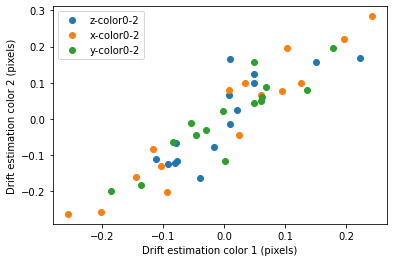

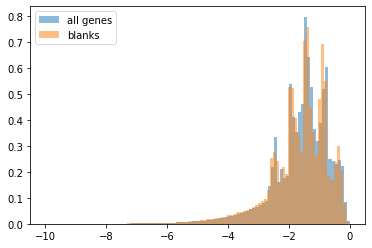

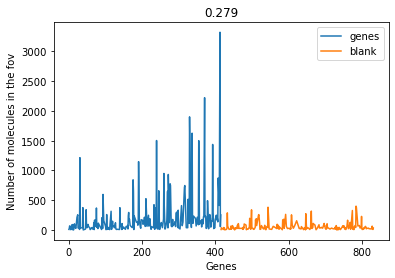

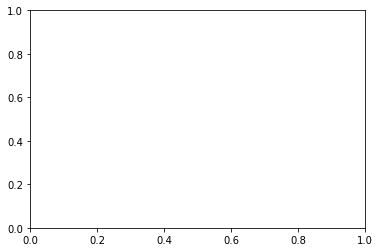

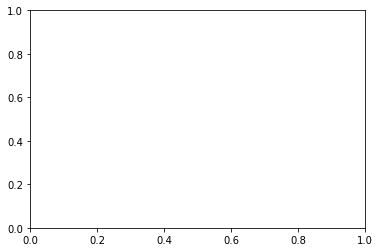

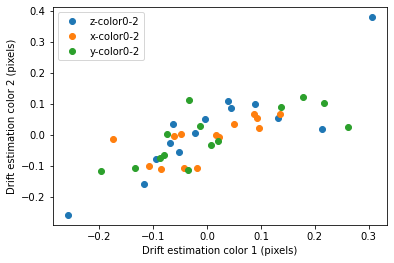

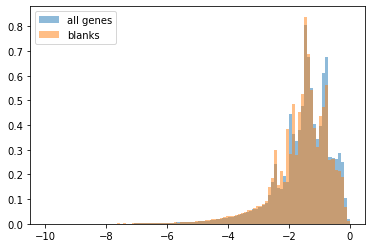

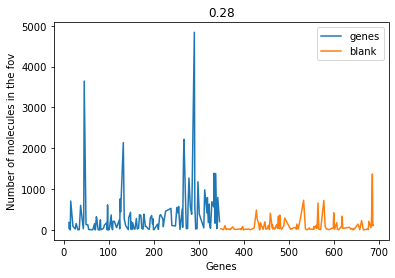

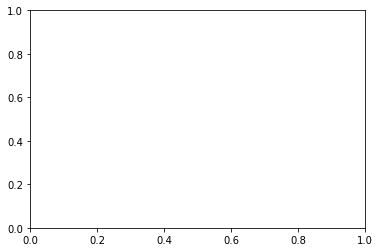

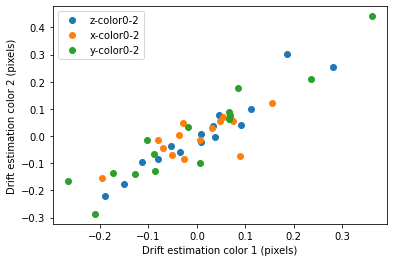

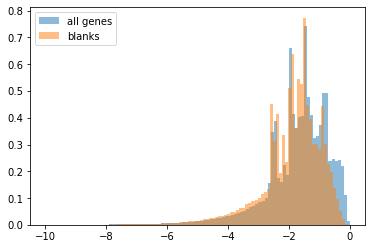

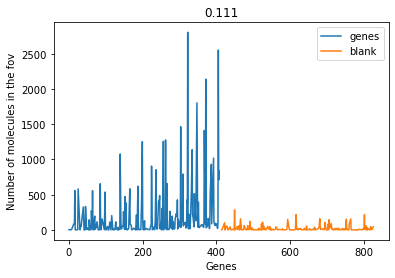

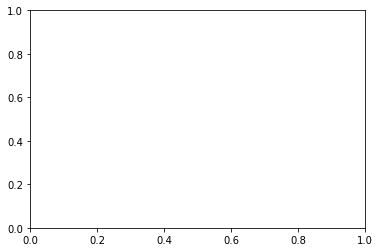

In [6]:
for fov,set_,save_folder in tqdm(paramaters[::-1]):
    try:
        main_analysisV1(fov,set_,
                       save_folder = save_folder,
                       save_fl_ref = r'\\192.168.0.6\bbfishjoy4extra\MERFISH_AnalysisP12\scoresRef.npy',
                       save_folder_all = r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\FinalDecodedSpotsV2',
                       drift_folder = r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\DriftAcrossDatasets',
                       segm_tag = 'A1_LamA_Nup98_D16')
    except:
        print("Failed at:",fov,set_,save_folder)